# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados do Experimento Univariado para a Previsão de 2020

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares multivariados na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Análise Univariada da Série de Arrecadação do ICMS Paulista 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima, nsdiffs, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(10,7)})

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
0,2003-01-01,3.360296e+09,277.173,3.4384,96.15,22,277.173,3.4384,96.15,277.173,...,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15
1,2003-02-01,3.196558e+09,283.506,3.5908,98.67,20,283.506,3.5908,98.67,283.506,...,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67
2,2003-03-01,3.160011e+09,287.855,3.4469,103.41,19,287.855,3.4469,103.41,287.855,...,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41
3,2003-04-01,3.215307e+09,290.512,3.1187,102.19,20,290.512,3.1187,102.19,290.512,...,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19
4,2003-05-01,3.098930e+09,289.747,2.9557,100.30,21,289.747,2.9557,100.30,289.747,...,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30


In [4]:
df_main_orig.tail(20)

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
220,2021-05-01,1.414623e+10,1069.289,5.291057,137.69,21,1069.289000,5.291057,137.690000,954.262926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,2021-06-01,1.465265e+10,1075.733,5.031905,137.91,21,1075.733000,5.031905,137.910000,956.744009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,2021-07-01,1.570838e+10,1084.095,5.156705,143.07,22,1084.095000,5.156705,143.070000,958.944520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,2021-08-01,1.597532e+10,1091.290,5.251718,141.97,22,1091.290000,5.251718,141.970000,961.725459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,2021-09-01,1.622460e+10,1084.312,5.279690,138.79,21,1084.312000,5.279690,138.790000,965.668534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,2021-10-01,1.664068e+10,1091.283,5.539980,138.02,20,1091.283000,5.539980,138.020000,970.014042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,2021-11-01,1.737603e+10,1091.483,5.556860,139.75,20,1091.483000,5.556860,139.750000,973.894098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,2021-12-01,1.853772e+10,1100.988,5.651391,141.61,23,1100.988000,5.651391,141.610000,977.984454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,2022-01-01,1.675250e+10,1120.999,5.534105,131.55,21,1107.263632,5.566200,134.311323,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,2022-02-01,1.582980e+10,1141.546,5.196579,136.57,20,1111.692686,5.550000,135.771385,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as linhas posteriores ao ano da previsão.

In [6]:
df_main = df_main_orig.iloc[0:216]
datas = df_main['date']

In [7]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
211,2020-08-01,1.227731e+10,832.313,5.461233,135.61,21,832.313,5.461233,135.61,832.313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,2020-09-01,1.309835e+10,868.442,5.399486,137.09,21,868.442,5.399486,137.09,868.442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,2020-10-01,1.387787e+10,896.505,5.625790,139.80,21,896.505,5.625790,139.80,896.505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,2020-11-01,1.474590e+10,925.887,5.417835,138.14,20,925.887,5.417835,138.14,925.887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,2020-12-01,1.490640e+10,934.758,5.145586,139.27,22,934.758,5.145586,139.27,934.758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Criação das Séries

In [8]:
icms_ts = pd.Series(list(df_main['icms_sp']), index = datas)

#### Testes de Valores Nulos

In [9]:
print('ICMS', icms_ts.isnull().sum())

ICMS 0


In [10]:
# listando os nulos do icms
icms_ts[icms_ts.isnull()]

Series([], dtype: float64)

In [11]:
# eliminando os nulos do icms
icms_ts = icms_ts[~icms_ts.isnull()]

In [12]:
icms_ts.shape

(216,)

### Plotando a Série em Nível

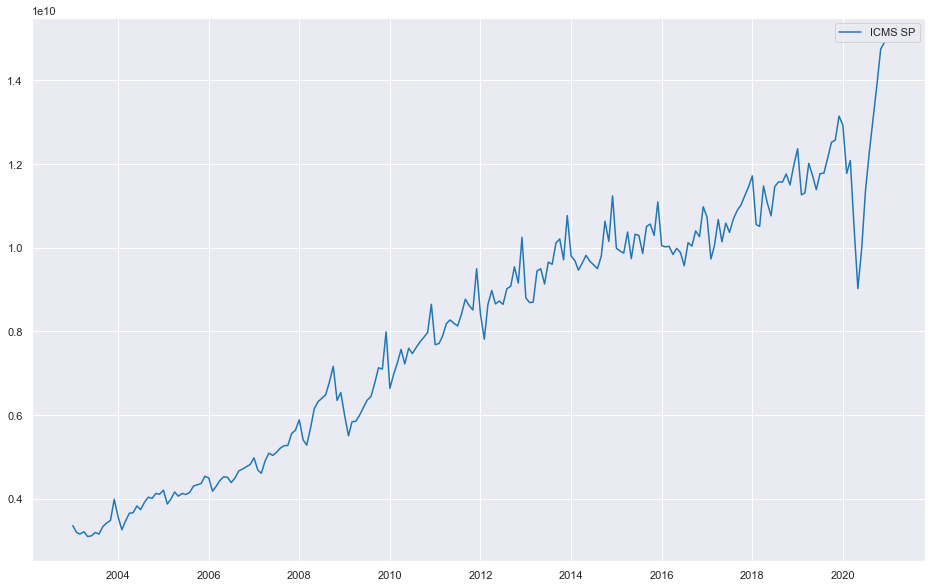

In [13]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(icms_ts, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
plt.show()

#### Últimos 24 meses da série

In [14]:
len(icms_ts['2020-01-01':'2020-12-01'])

12

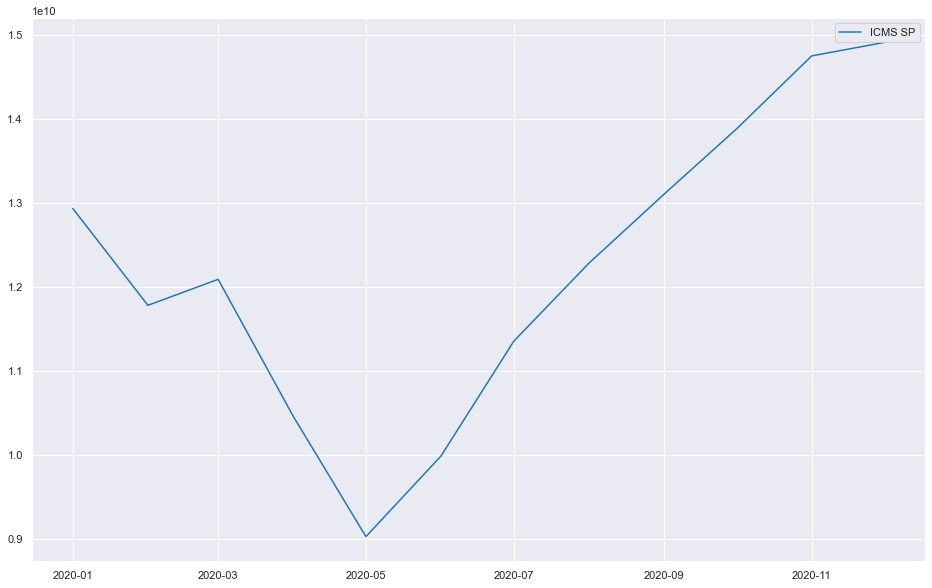

In [15]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(icms_ts['2020-01-01':'2020-12-01'], 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
plt.show()

### Série em Log
Como os valores do ICMS são muito elevados a série será colocada em log.

In [16]:
l_icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)

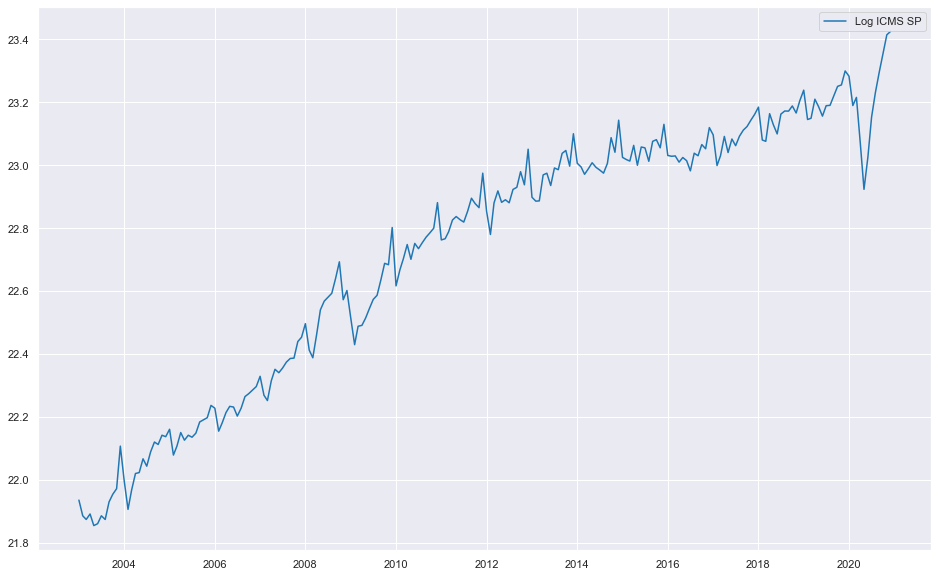

In [17]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(l_icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
plt.show()

### Série em Primeira Diferença

In [18]:
icms_ts_d1 = icms_ts.diff().dropna()
l_icms_ts_d1 = l_icms_ts.diff().dropna()

### Plotando as Séries em Primeira Diferença

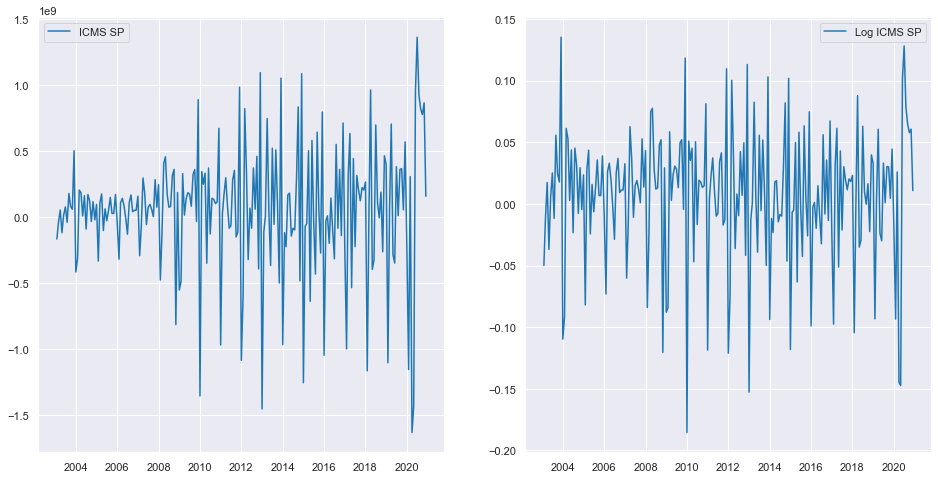

In [19]:
fig=plt.figure(figsize=(16, 8))
ax1=fig.add_subplot(121)
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2=fig.add_subplot(122)
ax2.plot(l_icms_ts_d1, 'tab:blue', label='Log ICMS SP')
ax2.legend(loc='best')
plt.show()

### Teste de Raiz Unitária da Série em Nível

Teste de raiz unitária Dickey-Fuller Aumentado (ADF): a hipótese nula é de que há raiz unitária e a série não é estacionária; a alternativa, de que não há e, portanto, a série é estacionária. 

Teste de raiz unitária Kwiatkowski-Phillips-Schmidt-Shin (KPSS): a hipótese nula é de que a série é de tendência estacionária; a alternativa é de há raiz unitária e a série não é estacionária.

A combinação dos dois testes pode ter os seguintes resultados com as seguintes consequências:

- Caso 1: Ambos os testes concluem que a série não é estacionária, então a série não é estacionária
- Caso 2: Ambos os testes concluem que a série é estacionária, então a série é estacionária
- Caso 3: o KPSS indica estacionariedade e o ADF indica não estacionariedade; a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência deve ser verificada quanto à estacionariedade.
- Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade; a série é estacionária diferencial. A diferenciação deve ser usada para tornar as séries estacionárias. A série diferenciada deve ser verificada quanto à estacionariedade.

**Fonte**: [Statsmodel](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [21]:
adf_test(l_icms_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.957093
p-value                          0.039100
#Lags Used                      12.000000
Number of Observations Used    203.000000
Critical Value (1%)             -3.462980
Critical Value (5%)             -2.875885
Critical Value (10%)            -2.574416
dtype: float64


In [22]:
kpss_test(l_icms_ts)

Results of KPSS Test:
Test Statistic           2.161444
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em nível: a 5%, rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série é estacionária de tendência e precisa ser posta em primeira diferença.

### Teste de Raiz Unitária da Série em Primeira Diferença
A série posta em primeira diferença será testadas para estacionariedade com os testes ADF e KPSS.

In [23]:
adf_test(l_icms_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.185976
p-value                          0.000696
#Lags Used                      12.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64


In [24]:
kpss_test(l_icms_ts_d1)

Results of KPSS Test:
Test Statistic           0.066441
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

In [25]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(icms_ts, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(icms_ts, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(icms_ts, test='pp')  # -> 0
n_adf, n_kpss, n_pp

(0, 1, 0)

### Dessazonalização da Série

In [26]:
sns.set(rc={'figure.figsize':(15,7)})

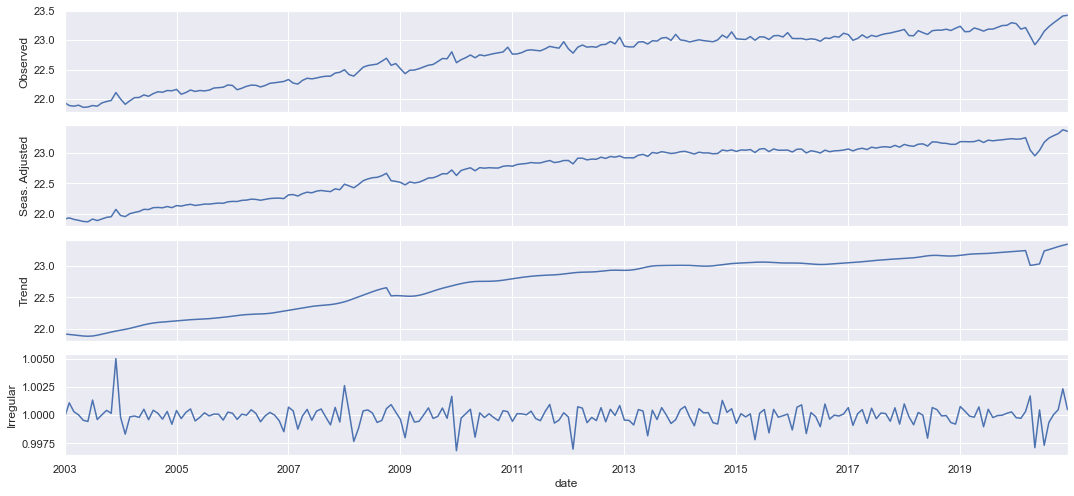

In [27]:
l_seas_icms = statsmodels.tsa.x13.x13_arima_analysis(l_icms_ts, x12path='./x13asmac/')
plot = l_seas_icms.plot()

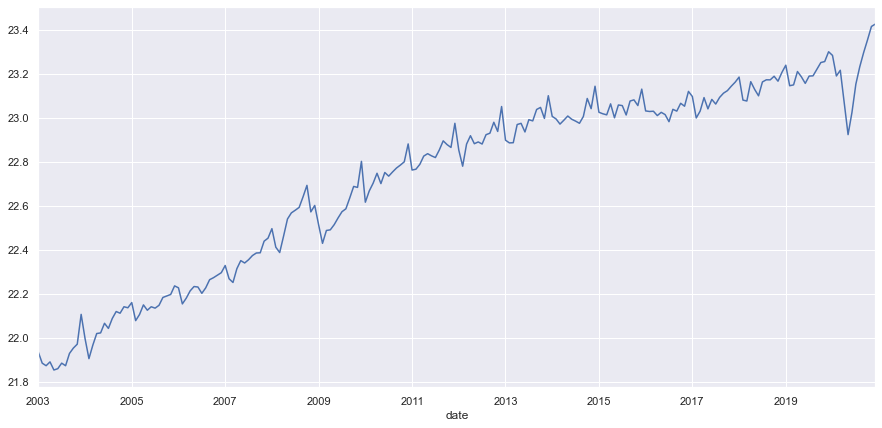

In [28]:
plot = l_seas_icms.observed.plot()

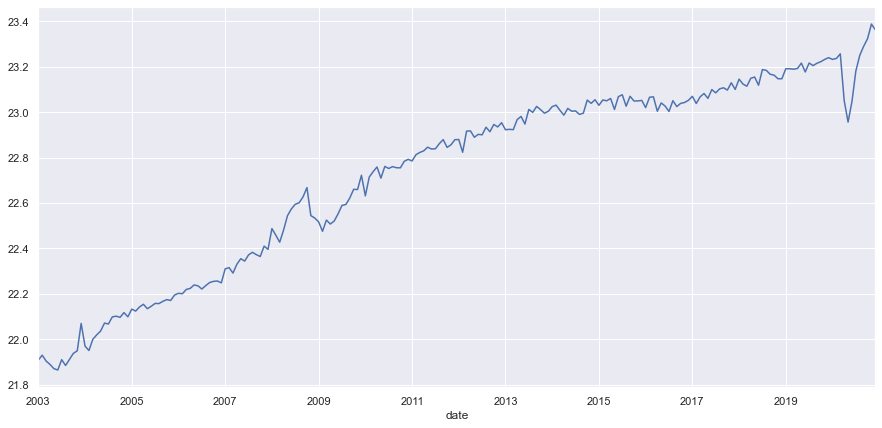

In [29]:
plot = l_seas_icms.seasadj.plot()

In [30]:
icms_decomp = pd.DataFrame(data={'ICMS observado': l_seas_icms.observed, 
                                 'ICMS desazonalizado': l_seas_icms.seasadj})

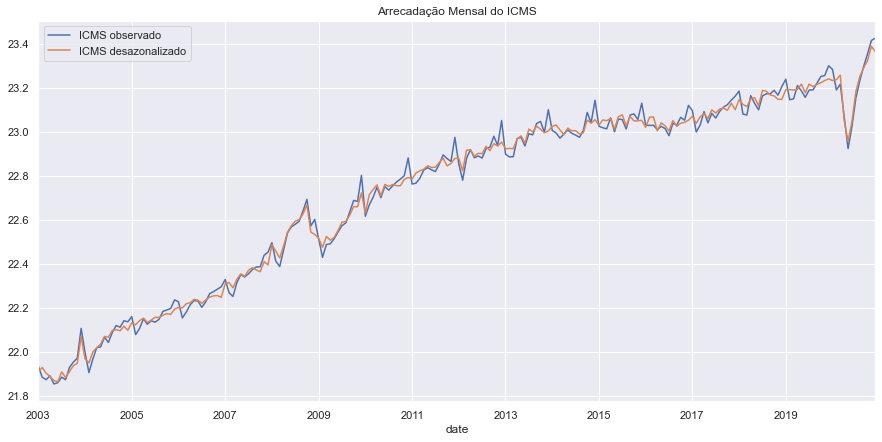

In [31]:
plot = icms_decomp.plot(title='Arrecadação Mensal do ICMS')

## Criando dummies de intervenção
Resultados do X13 Arima Seats para outliers e sazonalidade

In [32]:
pos = l_seas_icms.results.find('Outliers')
print(l_seas_icms.results[pos-309:pos+2105])

 ------------------------------------------------------------------------------
                             Parameter        Standard
 Variable                     Estimate           Error      t-value
 ------------------------------------------------------------------------------
 Automatically Identified Outliers
   AO2003.Dec                   0.0049         0.00122         3.99
   LS2008.Nov                  -0.0063         0.00110        -5.71
   LS2020.Apr                  -0.0106         0.00121        -8.79
   LS2020.Jul                   0.0082         0.00121         6.80
 ------------------------------------------------------------------------------


 ARIMA Model:  (2 1 0)(1 1 1)
   Nonseasonal differences: 1
   Seasonal differences:    1
                                              Standard
 Parameter                    Estimate          Errors
 -----------------------------------------------------
 Nonseasonal AR                                    
   Lag  1            

In [33]:
ls2008nov = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
dt_final = str(ls2008nov.index[-1])

ls2008nov['2008-11-01':dt_final] = 1
ls2020abr = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020abr['2020-04-01':dt_final ] = 1
ao2020mai = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ao2020mai['2020-05-01'] = 1
ls2020ago = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020ago['2020-08-01':dt_final ] = 1

In [34]:
ls2008nov.shape, ls2020abr.shape, ao2020mai.shape, ls2020ago.shape

((216,), (216,), (216,), (216,))

In [35]:
dummies_df = pd.DataFrame((ls2008nov, ls2020abr, ao2020mai, ls2020ago), 
                           index=['ls2008nov','ls2020abr', 'ao2020mai','ls2020ago'
                            ]).transpose()
dummies_df.head()

,ls2008nov,ls2020abr,ao2020mai,ls2020ago
2003-01-01,0.0,0.0,0.0,0.0
2003-02-01,0.0,0.0,0.0,0.0
2003-03-01,0.0,0.0,0.0,0.0
2003-04-01,0.0,0.0,0.0,0.0
2003-05-01,0.0,0.0,0.0,0.0


In [36]:
dummies_df.tail()

,ls2008nov,ls2020abr,ao2020mai,ls2020ago
2020-08-01,1.0,1.0,0.0,1.0
2020-09-01,1.0,1.0,0.0,1.0
2020-10-01,1.0,1.0,0.0,1.0
2020-11-01,1.0,1.0,0.0,1.0
2020-12-01,1.0,1.0,0.0,1.0


### Teste de Raiz Unitária Sazonal

In [37]:
D = nsdiffs(icms_ts, m=12, max_D=12, test='ch')
D

0

In [38]:
D = nsdiffs(icms_ts, m=12, max_D=12, test='ocsb')
D

0

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Será usada a série em log, com sazonalidade e em nível. O modelo SARIMA irá lidar com a sazonalidade e a não estacionariedade. A série out-of-sample não vai estar em log para que o resultado seja real.

In [39]:
icms_train = l_icms_ts[:-12]
icms_test = icms_ts[-12:]

In [40]:
icms_train

date
2003-01-01    21.935295
2003-02-01    21.885340
2003-03-01    21.873841
2003-04-01    21.891189
2003-05-01    21.854323
                ...    
2019-08-01    23.190011
2019-09-01    23.220380
2019-10-01    23.250368
2019-11-01    23.254939
2019-12-01    23.299403
Length: 204, dtype: float64

In [41]:
icms_test

date
2020-01-01    1.292981e+10
2020-02-01    1.177686e+10
2020-03-01    1.208593e+10
2020-04-01    1.045560e+10
2020-05-01    9.023529e+09
2020-06-01    9.983544e+09
2020-07-01    1.134873e+10
2020-08-01    1.227731e+10
2020-09-01    1.309835e+10
2020-10-01    1.387787e+10
2020-11-01    1.474590e+10
2020-12-01    1.490640e+10
dtype: float64

In [42]:
dummies = dummies_df[:].to_numpy()
dummies_train = dummies[:-12]
dummies_test = dummies[-12:]
print(dummies.shape, dummies_train.shape, dummies_test.shape)

(216, 4) (204, 4) (12, 4)


## Utilidades para Previsões

Além de MAPE e MSE, será usado o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [43]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões
Será usado para armazenar todas as previsões.

In [44]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos Baseline
A média e a média móvel 12 meses do ano anterior (2021) serão usadas como o baseline da previsão como modelos naïve.

### Média

In [45]:
y_mean_pred = pd.Series(np.ones(12) * icms_ts[-24:-12].mean())
y_mean_pred.index = icms_test.index
y_mean_pred

date
2020-01-01    1.200177e+10
2020-02-01    1.200177e+10
2020-03-01    1.200177e+10
2020-04-01    1.200177e+10
2020-05-01    1.200177e+10
2020-06-01    1.200177e+10
2020-07-01    1.200177e+10
2020-08-01    1.200177e+10
2020-09-01    1.200177e+10
2020-10-01    1.200177e+10
2020-11-01    1.200177e+10
2020-12-01    1.200177e+10
dtype: float64

In [46]:
previsoes['nome'].append('Mean')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_mean_pred)

In [47]:
RMSE_mean = mean_squared_error(icms_test, y_mean_pred, squared=False)
previsoes['rmse'].append(RMSE_mean)
RMSE_mean

1766457619.5914745

In [48]:
MAPE_mean = mean_absolute_percentage_error(icms_test, y_mean_pred)
previsoes['mape'].append(MAPE_mean)
MAPE_mean

0.12148070708014828

In [49]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_mean_pred, icms_test)])

### Comparação do modelo naïve com o real

In [50]:
prev_naive_df = pd.DataFrame(data={"Mean": previsoes['previsoes'][0]})
prev_naive_df['real'] = icms_test
prev_naive_df

,Mean,real
date,,
2020-01-01,1.200177e+10,1.292981e+10
2020-02-01,1.200177e+10,1.177686e+10
2020-03-01,1.200177e+10,1.208593e+10
2020-04-01,1.200177e+10,1.045560e+10
2020-05-01,1.200177e+10,9.023529e+09
2020-06-01,1.200177e+10,9.983544e+09
2020-07-01,1.200177e+10,1.134873e+10
2020-08-01,1.200177e+10,1.227731e+10
2020-09-01,1.200177e+10,1.309835e+10


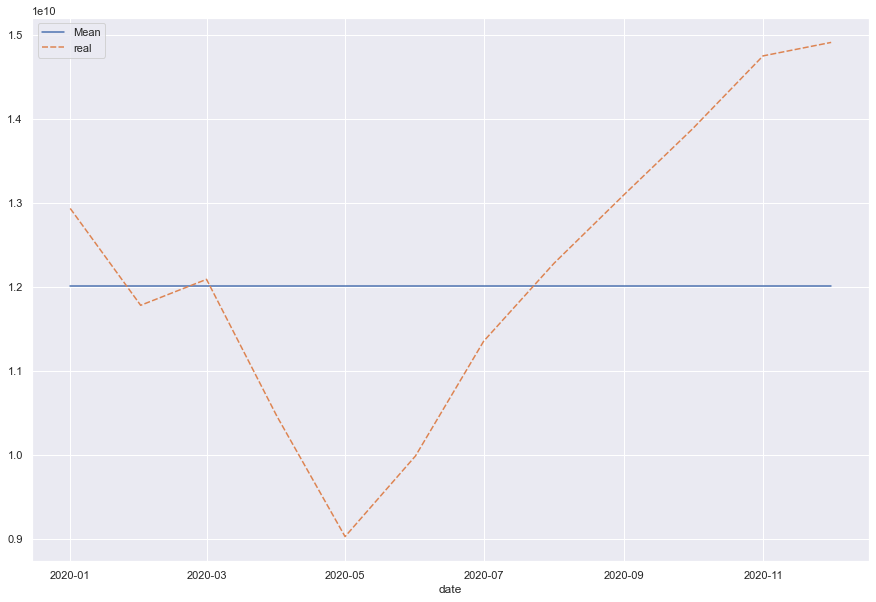

In [51]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_naive_df)

## Modelos ARIMA sem Dummies de Intervenção

### Auto Arima da Série

#### Critério de Akaike

In [52]:
mod_aa_aic = auto_arima(icms_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_aic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

#### Critério de Schwarz

In [53]:
mod_aa_bic = auto_arima(icms_train, stationary=False, seasonal=True, m=12,
                        information_criterion='bic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_bic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMA(0,1,1),(1,0,1) sugerido pelo critério de Akaike e Schwarz

In [54]:
mod_arima1 = ARIMA(icms_train, order=(0,1,1), seasonal_order=(1,0,1,12))
res_arima1 = mod_arima1.fit()
print(res_arima1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  204
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 384.316
Date:                          Wed, 12 Jul 2023   AIC                           -760.631
Time:                                  12:15:55   BIC                           -747.378
Sample:                              01-01-2003   HQIC                          -755.270
                                   - 12-01-2019                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4685      0.045    -10.488      0.000      -0.556      -0.381
ar.S.L12       0.9369      0.029     31.913      0.

#### Análise dos Resíduos

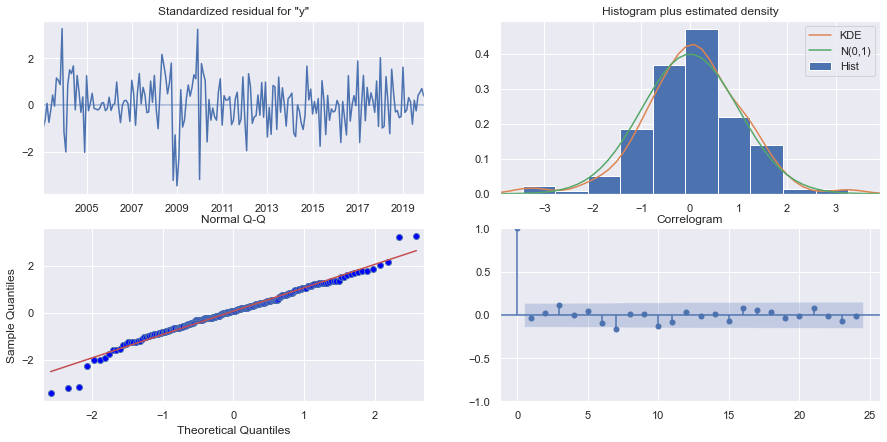

In [55]:
ax = res_arima1.plot_diagnostics(lags=24)

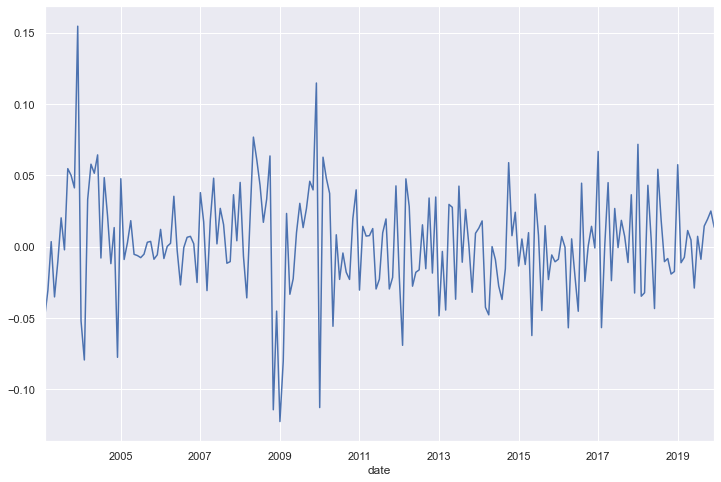

In [56]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima1.resid[1:].plot(ax=ax)

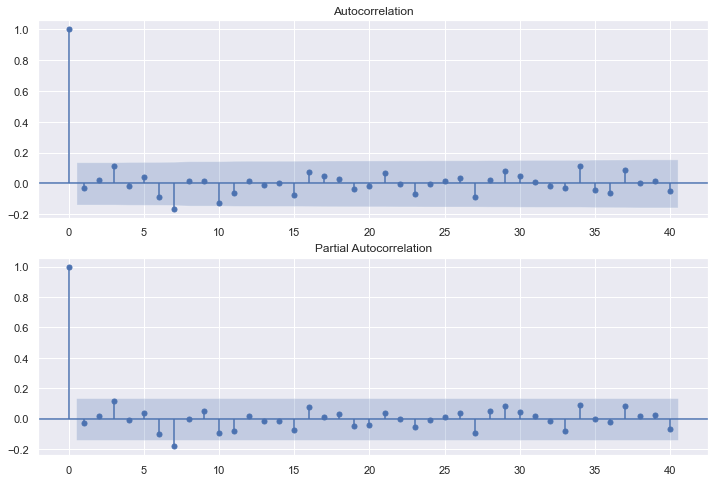

In [57]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima1.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima1.resid[1:], lags=40, ax=ax2)

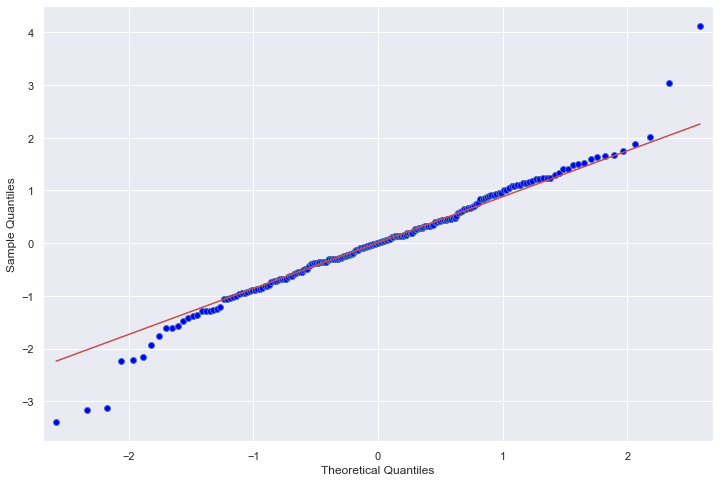

In [58]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima1.resid[1:], line="q", ax=ax, fit=True)

#### Previsões

In [59]:
previsoes['nome'].append('SARIMA(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima1)

In [60]:
y_arima1_pred = np.exp(res_arima1.forecast(12))
previsoes['previsoes'].append(y_arima1_pred)

In [61]:
RMSE_arima1 = mean_squared_error(icms_test, y_arima1_pred, squared=False)
previsoes['rmse'].append(RMSE_arima1)
RMSE_arima1

1579590696.4547958

In [62]:
MAPE_arima1 = mean_absolute_percentage_error(icms_test, y_arima1_pred)
previsoes['mape'].append(MAPE_arima1)
MAPE_arima1

0.10752382874425252

In [63]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima1_pred, icms_test)])

#### Comparação com o Real

In [64]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][1]: previsoes['previsoes'][1]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMA(0,1,1),(1,0,1)",real
2020-01-01,1.292716e+10,1.292981e+10
2020-02-01,1.213299e+10,1.177686e+10
2020-03-01,1.219420e+10,1.208593e+10
2020-04-01,1.278760e+10,1.045560e+10
2020-05-01,1.250958e+10,9.023529e+09
2020-06-01,1.240393e+10,9.983544e+09
2020-07-01,1.262892e+10,1.134873e+10
2020-08-01,1.273947e+10,1.227731e+10
2020-09-01,1.295523e+10,1.309835e+10
2020-10-01,1.322048e+10,1.387787e+10


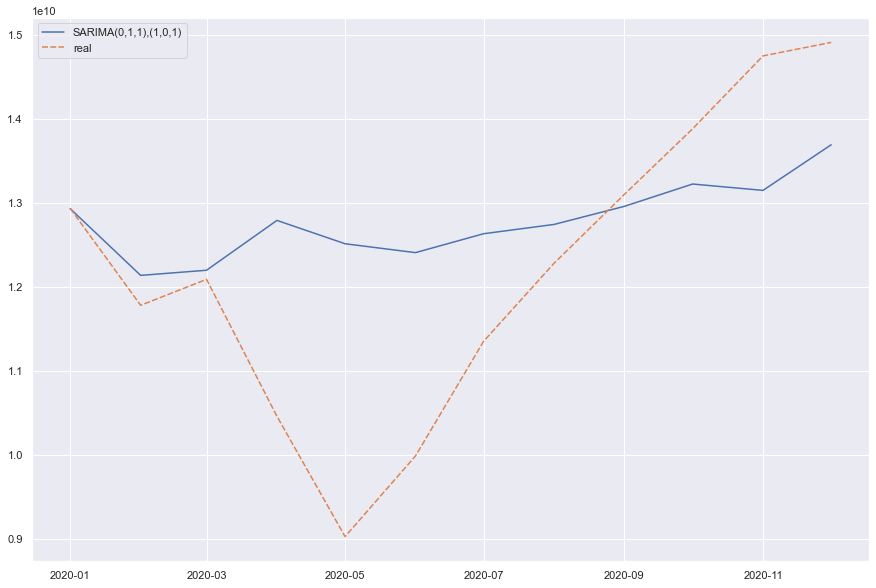

In [65]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

## Modelos ARIMA com Dummies de Intervenção

### Auto Arima da Série

#### Critério de Akaike

In [66]:
mod_aa_aic_dum = auto_arima(icms_train, X=dummies_train, d=1, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_aic_dum

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [67]:
mod_aa_bic_dum = auto_arima(icms_train, x=dummies_train, d=1, stationary=False, seasonal=True, m=12, 
                        information_criterion='bic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_bic_dum

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMAX(0,1,1),(2,0,1) sugerido pelos critérios de Akaike
Mesmo modelo sugerido para a série sem as dummies de intervenção.

In [68]:
mod_arima3 = ARIMA(icms_train, exog=dummies_train, order=(0,1,1), seasonal_order=(2,0,1,12))
res_arima3 = mod_arima3.fit()
print(res_arima3.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  204
Model:             ARIMA(0, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 400.539
Date:                          Wed, 12 Jul 2023   AIC                           -783.078
Time:                                  12:17:36   BIC                           -753.259
Sample:                              01-01-2003   HQIC                          -771.014
                                   - 12-01-2019                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1447      0.026     -5.621      0.000      -0.195      -0.094
const               0      0.049          0      1.

#### Análise dos Resíduos

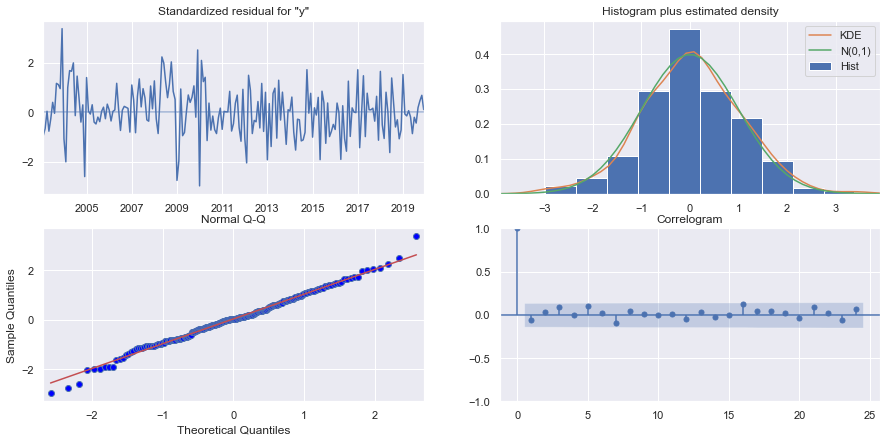

In [69]:
ax = res_arima3.plot_diagnostics(lags=24)

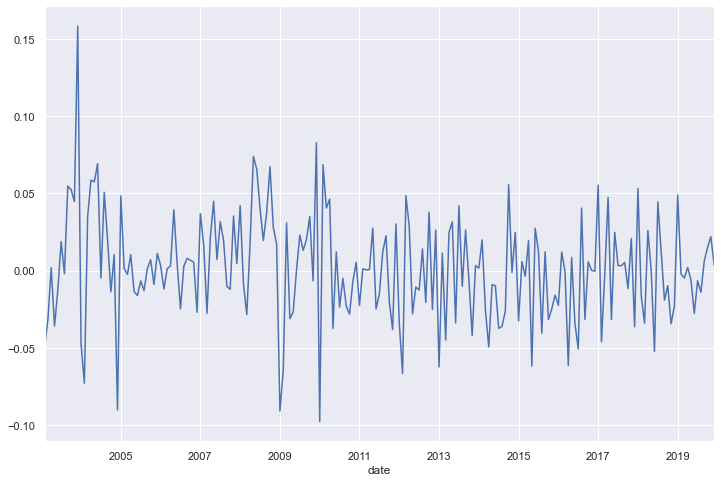

In [70]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima3.resid[1:].plot(ax=ax)

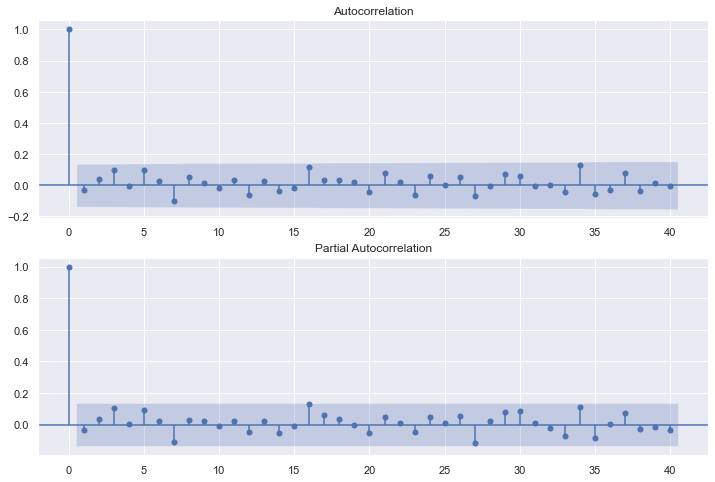

In [71]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima3.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima3.resid[1:], lags=40, ax=ax2)

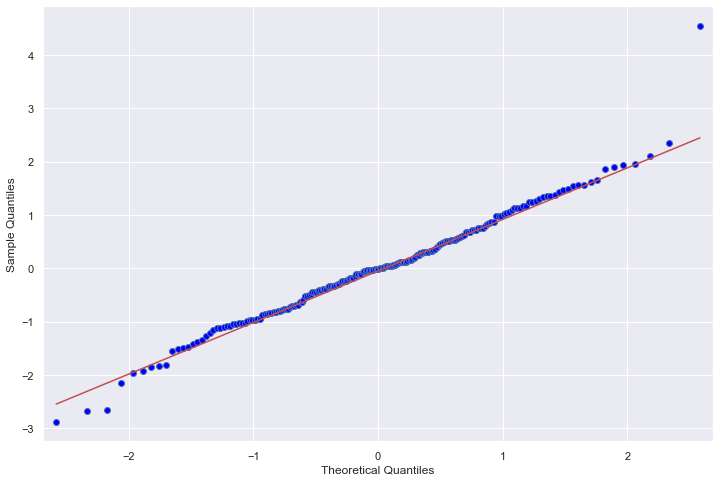

In [72]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima3.resid[1:], line="q", ax=ax, fit=True)

### Previsões

In [73]:
previsoes['nome'].append('SARIMAX(0,1,1),(2,0,1)')
previsoes['modelo'].append(res_arima3)

In [74]:
y_arima3_pred = np.exp(res_arima3.forecast(12, exog=dummies_test))
previsoes['previsoes'].append(y_arima3_pred)

In [75]:
RMSE_arima3 = mean_squared_error(icms_test, y_arima3_pred, squared=False)
previsoes['rmse'].append(RMSE_arima3)
RMSE_arima3

1550802363.8934634

In [76]:
MAPE_arima3 = mean_absolute_percentage_error(icms_test, y_arima3_pred)
previsoes['mape'].append(MAPE_arima3)
MAPE_arima3

0.102831747449159

In [77]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima3_pred, icms_test)])

### Modelo SARIMAX(0,1,1),(1,0,1) sugerido pelos critérios de Schwarz
Mesmo modelo sugerido para a série sem as dummies de intervenção.

In [78]:
mod_arima4 = ARIMA(icms_train, exog=dummies_train, order=(0,1,1), seasonal_order=(1,0,1,12))
res_arima4 = mod_arima4.fit()
print(res_arima4.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  204
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 396.474
Date:                          Wed, 12 Jul 2023   AIC                           -776.947
Time:                                  12:17:38   BIC                           -750.442
Sample:                              01-01-2003   HQIC                          -766.224
                                   - 12-01-2019                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1384      0.025     -5.498      0.000      -0.188      -0.089
const               0   1411.302          0      1.

#### Análise dos Resíduos

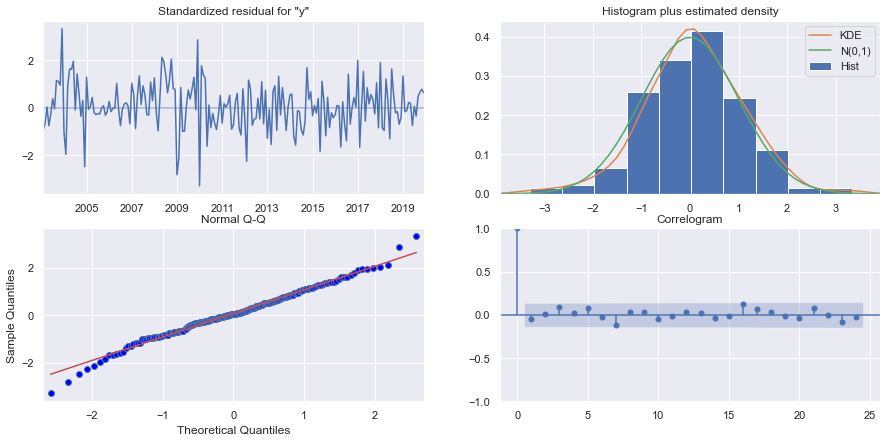

In [79]:
ax = res_arima4.plot_diagnostics(lags=24)

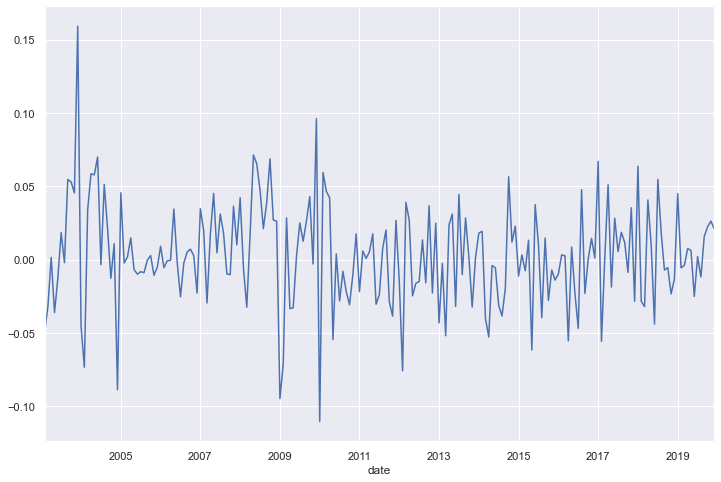

In [80]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima4.resid[1:].plot(ax=ax)

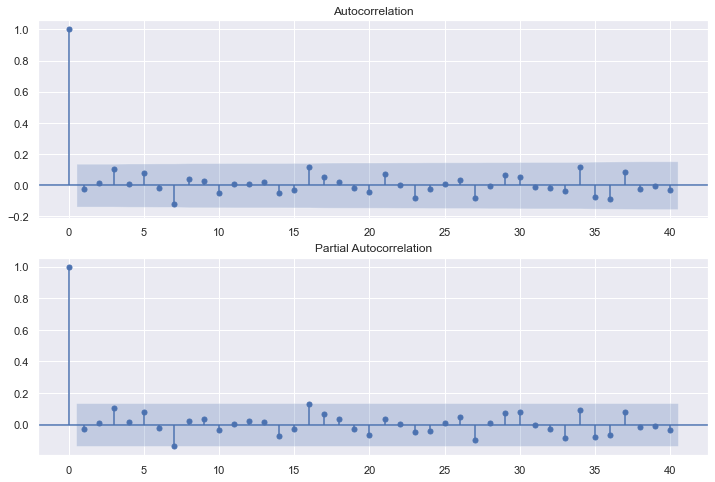

In [81]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima4.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima4.resid[1:], lags=40, ax=ax2)

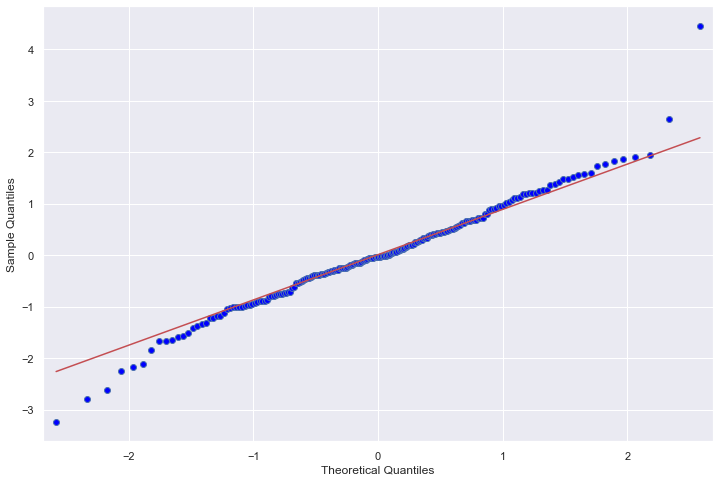

In [82]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima4.resid[1:], line="q", ax=ax, fit=True)

### Previsões

In [83]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima4)

In [84]:
y_arima4_pred = np.exp(res_arima4.forecast(12, exog=dummies_test))
previsoes['previsoes'].append(y_arima4_pred)

In [85]:
RMSE_arima4 = mean_squared_error(icms_test, y_arima4_pred, squared=False)
previsoes['rmse'].append(RMSE_arima4)
RMSE_arima4

1588928131.783356

In [86]:
MAPE_arima4 = mean_absolute_percentage_error(icms_test, y_arima4_pred)
previsoes['mape'].append(MAPE_arima4)
MAPE_arima4

0.108920325712761

In [87]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima4_pred, icms_test)])

### Comparação dos modelos SARIMA

In [88]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][1]: previsoes['previsoes'][1],
                                 previsoes['nome'][2]: previsoes['previsoes'][2],
                                 previsoes['nome'][3]: previsoes['previsoes'][3]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(2,0,1)","SARIMAX(0,1,1),(1,0,1)",real
2020-01-01,1.292716e+10,1.284862e+10,1.304511e+10,1.292981e+10
2020-02-01,1.213299e+10,1.206016e+10,1.215646e+10,1.177686e+10
2020-03-01,1.219420e+10,1.218289e+10,1.220650e+10,1.208593e+10
2020-04-01,1.278760e+10,1.276597e+10,1.284116e+10,1.045560e+10
2020-05-01,1.250958e+10,1.259812e+10,1.254769e+10,9.023529e+09
2020-06-01,1.240393e+10,1.251144e+10,1.238706e+10,9.983544e+09
2020-07-01,1.262892e+10,1.270431e+10,1.266966e+10,1.134873e+10
2020-08-01,1.273947e+10,1.280813e+10,1.276675e+10,1.227731e+10
2020-09-01,1.295523e+10,1.318015e+10,1.298013e+10,1.309835e+10
2020-10-01,1.322048e+10,1.349401e+10,1.324608e+10,1.387787e+10


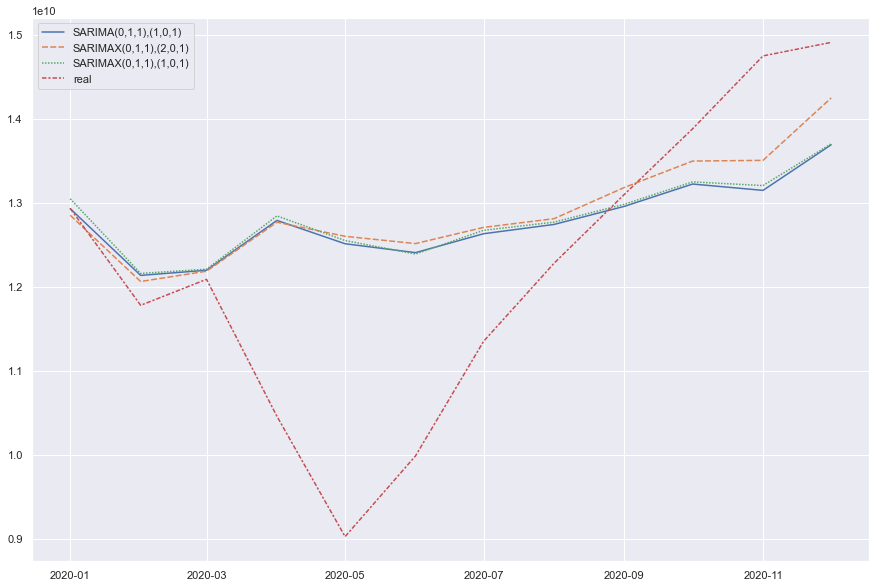

In [89]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

## Modelo de Markov-Switching

A biblioteca statsmodel não tem implementado o método de forecast do modelo de Markov Switching. Por isso o forecast foi realizado no Ox e os dados estão sendo importados aqui.
Foram feitos 3 modelos usando as mesmas variáveis e 2 mudanças de regime:
- log icms em primeira diferença - Y
- constante - mudança de regime (*regime switching*)
- loc icms em primeira diferença com uma defasagem - (*regime switching*) 
- 11 dummies sazonais - X (variável)

E foram usados 3 tipos de variância
- variância fixa (*fixed variance*)
- mudança de variância (*switching variance*)
- componente média-variância (*mean-variance component*)

In [90]:
markov_forecast_df = pd.read_csv('forecast_markov.csv', delimiter=';', decimal=',')
markov_forecast_df = markov_forecast_df[-36:-24]
markov_forecast_df.tail()

,Unnamed: 0,date,icms_sp,igp_m,ibc_br,dias_uteis,Licms_sp,DLicms_sp,D2igp_m,Dibc_br,...,14_forecast_uni_var,13_forecast_uni_fixed,13_forecast_uni_var,13_forecast_uni_mean_var,13_forecast_multi_var,13_forecast_multi_mean_var,14_forecast_multi_fixed,14_forecast_multi_mean_var,14_forecast_multi_var,14_forecast_uni_mean_var
211,2020(8),2020-08-01,12277307781,832.313,135.61,21,23.231019,0.078647,39.884,-0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,2020(9),2020-09-01,13098349990,868.442,137.09,21,23.295752,0.064734,58.359,1.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,2020(10),2020-10-01,13877865859,896.505,139.80,21,23.353561,0.057809,64.192,2.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,2020(11),2020-11-01,14745896346,925.887,138.14,20,23.414231,0.060670,57.445,-1.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,2020(12),2020-12-01,14906401855,934.758,139.27,22,23.425057,0.010826,38.253,1.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Variância Fixa

In [91]:
arq1 = open('./ox/20_results_uni_fixed.txt', 'r')
print(arq1.read())
arq1.close()


Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- Switching - PcGive 2.08 session started at 13:36:30 on 25-06-2023 ----

Switching( 1) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-03-01 - 2019-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal         -0.0843087     0.01143    -7.38   0.000
CSeasonal_1        -0.139409     0.01239    -11.2   0.000
CSeasonal_2       -0.0709635     0.01029    -6.89   0.000
CSeasonal_3       -0.0178266     0.01025    -1.74   0.084
CSeasonal_4       -0.0517205     0.01102    -4.69   0.000
CSeasonal_5       -0.0599596    0.009984    -6.01   0.000
CSeasonal_6       -0.0560616     0.01025    -5.47   0.000
CSeasonal_7       -0.0500837     0.01015    -4.93   0.000
CSeasonal_8       -0.0266905     0.01031    -2.59   0.010
CSeasonal_9       -0.0315158     0.01087    -2.90   

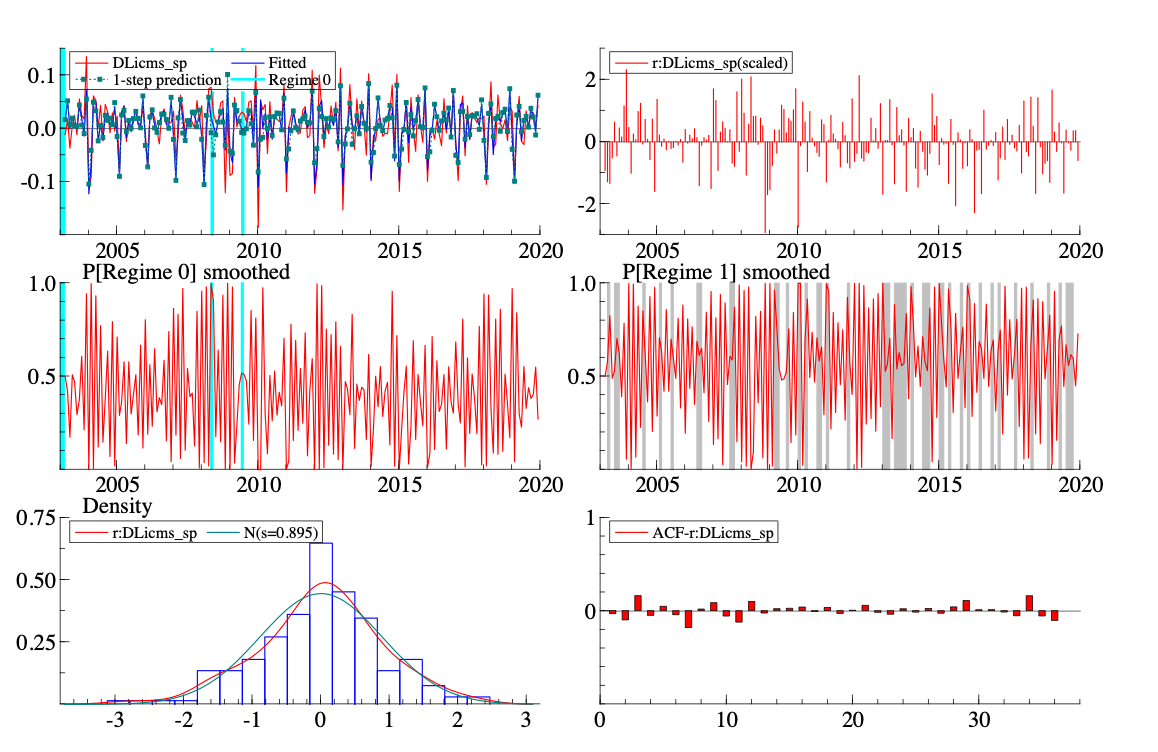

#### Previsões

In [92]:
y_markov_fixed_pred = np.exp(np.cumsum(markov_forecast_df['20_forecast_uni_fixed'])+icms_train[-1])
y_markov_fixed_pred.index = icms_test.index
y_markov_fixed_pred

date
2020-01-01    1.269711e+10
2020-02-01    1.197300e+10
2020-03-01    1.220293e+10
2020-04-01    1.268726e+10
2020-05-01    1.264958e+10
2020-06-01    1.273274e+10
2020-07-01    1.281468e+10
2020-08-01    1.297460e+10
2020-09-01    1.341316e+10
2020-10-01    1.367606e+10
2020-11-01    1.359979e+10
2020-12-01    1.455208e+10
Name: 20_forecast_uni_fixed, dtype: float64

In [93]:
previsoes['nome'].append('Markov-Fixed')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred)

In [94]:
RMSE_markov_fixed = mean_squared_error(icms_test, y_markov_fixed_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed)
RMSE_markov_fixed

1581326156.6311243

In [95]:
MAPE_markov_fixed = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred)
previsoes['mape'].append(MAPE_markov_fixed)
MAPE_markov_fixed

0.10508571969334286

In [96]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred, icms_test)])

### Modelo com Mudança de Variância

In [97]:
arq2 = open('./ox/20_results_uni_var.txt', 'r')
print(arq2.read())
arq2.close()

---- OxMetrics 8.10 started at 11:36:07 on 12-Jul-2023 ----

OxMetrics-8

variaveis_previsao.xlsx loaded from /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx


Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- PcGive 15.20 session started at 11:36:26 on 12-07-2023 ----

---- Switching - PcGive 2.08 session started at 11:36:36 on 12-07-2023 ----

Switching( 2) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-03-01 - 2019-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal         -0.0956795    0.002181    -43.9   0.000
CSeasonal_1        -0.142778    0.002333    -61.2   0.000
CSeasonal_2       -0.0635294    0.001830    -34.7   0.000
CSeasonal_3      -0.00777901    0.002052    -3.79   0.000
CSeasonal_4       -0.0578429    0.002599    -22.3   0.000
CSeasonal_5       -0.0549

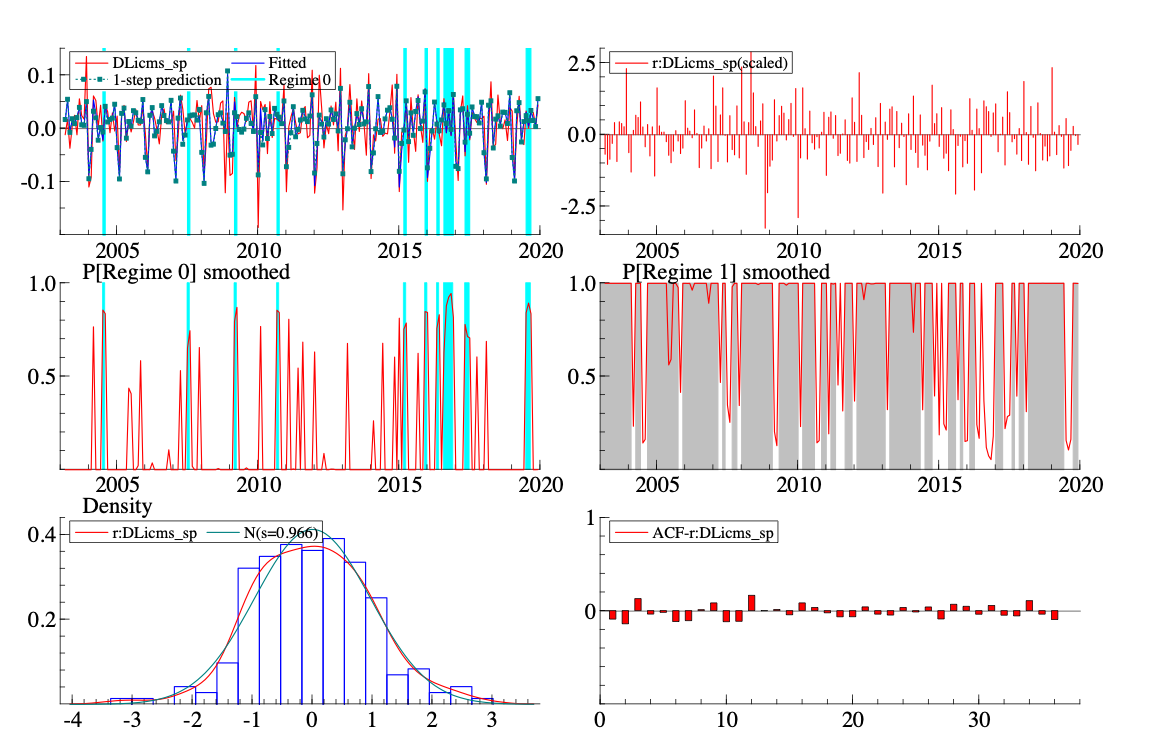

#### Previsões

In [98]:
y_markov_switching_pred = np.exp(np.cumsum(markov_forecast_df['20_forecast_uni_var'])+icms_train[-1])
y_markov_switching_pred.index = icms_test.index
y_markov_switching_pred

date
2020-01-01    1.242665e+10
2020-02-01    1.169312e+10
2020-03-01    1.193485e+10
2020-04-01    1.243772e+10
2020-05-01    1.221894e+10
2020-06-01    1.234891e+10
2020-07-01    1.243601e+10
2020-08-01    1.278688e+10
2020-09-01    1.308183e+10
2020-10-01    1.335084e+10
2020-11-01    1.345052e+10
2020-12-01    1.420604e+10
Name: 20_forecast_uni_var, dtype: float64

In [99]:
previsoes['nome'].append('Markov-Switching-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred)

In [100]:
RMSE_markov_switching = mean_squared_error(icms_test, y_markov_switching_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_switching)
RMSE_markov_switching

1411436552.306663

In [101]:
MAPE_markov_switching = mean_absolute_percentage_error(icms_test, y_markov_switching_pred)
previsoes['mape'].append(MAPE_markov_switching)
MAPE_markov_switching

0.09587727192395802

In [102]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred, icms_test)])

### Componente Média-Variância

In [103]:
arq3 = open('./ox/20_results_uni_mean_var.txt', 'r')
print(arq3.read())
arq3.close()


Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- Switching - PcGive 2.08 session started at 14:40:37 on 25-06-2023 ----

Switching( 1) Modelling DLicms_sp by MS_Component(2, 2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-03-01 - 2019-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal         -0.0808589     0.01282    -6.31   0.000
CSeasonal_1        -0.138650     0.01247    -11.1   0.000
CSeasonal_2       -0.0713954     0.01033    -6.91   0.000
CSeasonal_3       -0.0161592     0.01044    -1.55   0.123
CSeasonal_4       -0.0518680     0.01133    -4.58   0.000
CSeasonal_5       -0.0605179     0.01010    -5.99   0.000
CSeasonal_6       -0.0573585     0.01019    -5.63   0.000
CSeasonal_7       -0.0492985     0.01005    -4.91   0.000
CSeasonal_8       -0.0270311     0.01019    -2.65   0.009
CSeasonal_9       -0.0305349     0.0106

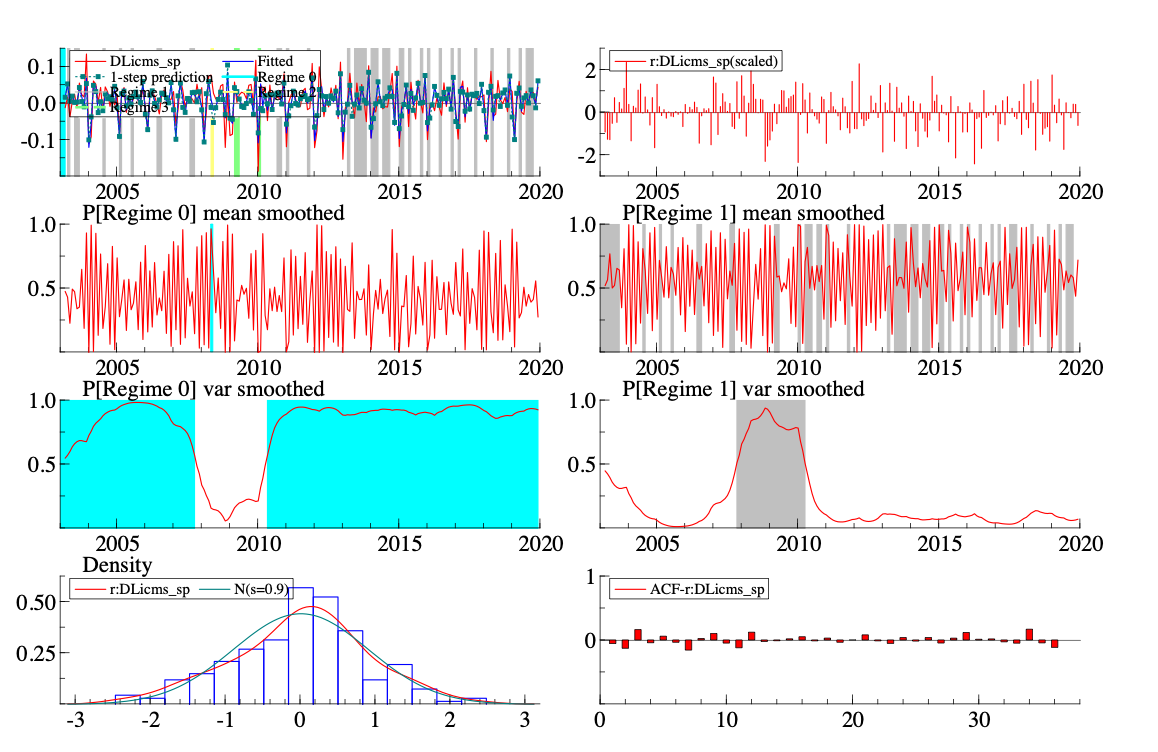

#### Previsões

In [104]:
y_markov_mean_var_pred = np.exp(np.cumsum(markov_forecast_df['20_forecast_uni_mean_var'])+icms_train[-1])
y_markov_mean_var_pred.index = icms_test.index
y_markov_mean_var_pred

date
2020-01-01    1.271702e+10
2020-02-01    1.199506e+10
2020-03-01    1.223033e+10
2020-04-01    1.271748e+10
2020-05-01    1.265548e+10
2020-06-01    1.273489e+10
2020-07-01    1.279110e+10
2020-08-01    1.296142e+10
2020-09-01    1.337608e+10
2020-10-01    1.364001e+10
2020-11-01    1.357202e+10
2020-12-01    1.451076e+10
Name: 20_forecast_uni_mean_var, dtype: float64

In [105]:
previsoes['nome'].append('Markov-Mean-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred)

In [106]:
RMSE_markov_mean_var = mean_squared_error(icms_test, y_markov_mean_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var)
RMSE_markov_mean_var

1586597489.5643442

In [107]:
MAPE_markov_mean_var = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred)
previsoes['mape'].append(MAPE_markov_mean_var)
MAPE_markov_mean_var

0.10572163324155576

In [108]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred, icms_test)])

#### Resultados dos Modelos de Markov

In [109]:
previsoes['nome']

['Mean',
 'SARIMA(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var']

In [110]:
prev_markov_df = pd.DataFrame(data={previsoes['nome'][4]: previsoes['previsoes'][4],
                                    previsoes['nome'][5]: previsoes['previsoes'][5],
                                    previsoes['nome'][6]: previsoes['previsoes'][6]
                                   })
prev_markov_df['real'] = icms_test
prev_markov_df

,Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,real
date,,,,
2020-01-01,1.269711e+10,1.242665e+10,1.271702e+10,1.292981e+10
2020-02-01,1.197300e+10,1.169312e+10,1.199506e+10,1.177686e+10
2020-03-01,1.220293e+10,1.193485e+10,1.223033e+10,1.208593e+10
2020-04-01,1.268726e+10,1.243772e+10,1.271748e+10,1.045560e+10
2020-05-01,1.264958e+10,1.221894e+10,1.265548e+10,9.023529e+09
2020-06-01,1.273274e+10,1.234891e+10,1.273489e+10,9.983544e+09
2020-07-01,1.281468e+10,1.243601e+10,1.279110e+10,1.134873e+10
2020-08-01,1.297460e+10,1.278688e+10,1.296142e+10,1.227731e+10
2020-09-01,1.341316e+10,1.308183e+10,1.337608e+10,1.309835e+10


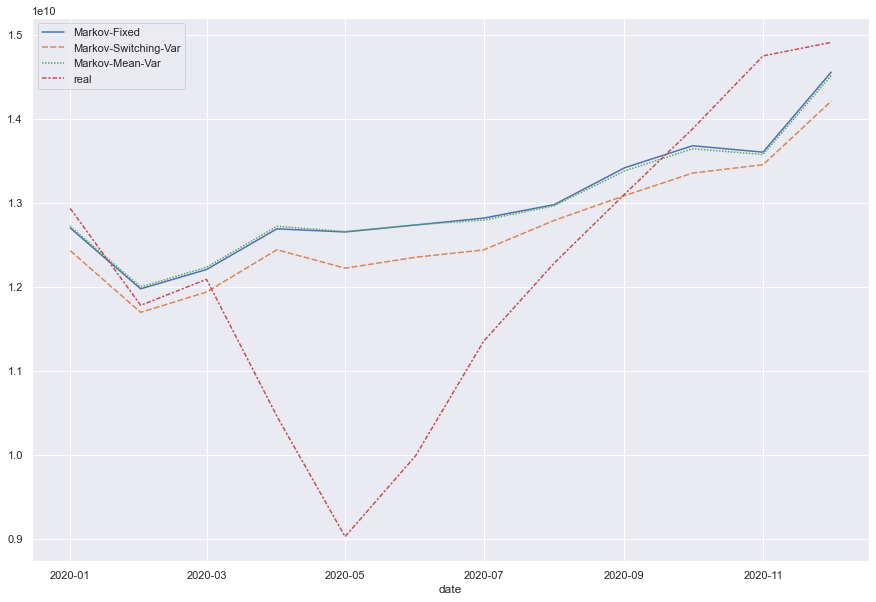

In [111]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_markov_df)

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série
As redes neurais precisam de conjuntos de características e de etiquetas separados. Neste caso, o conjunto de etiquetas é a própria série de ICMS. Para os conjunto de caraterísticas será utilizada a série do ICMS com lags 1, 2, 3, 4, 6 e 12 defasagens, e médias móveis de 2, 3, 6 e 12 meses, conforme trabalho de [Silva & Figueiredo, 2020].

In [112]:
def cria_features_target(serie, verbose=0):
    serie_d1 = serie.shift(1)
    serie_d2 = serie.shift(2)
    serie_d3 = serie.shift(3)
    serie_d4 = serie.shift(4)
    serie_d6 = serie.shift(6)
    serie_d12 = serie.shift(12)
    serie_ma2 = serie.rolling(2).mean()
    serie_ma3 = serie.rolling(3).mean()
    serie_ma6 = serie.rolling(6).mean()
    serie_ma12 = serie.rolling(12).mean()

    if verbose==1:
        print("shape de cada uma das séries:")
        print(serie_d1.shape, serie_d2.shape, serie_d3.shape, serie_d4.shape, 
              serie_d6.shape, serie_d12.shape, serie_ma2.shape, serie_ma3.shape, 
              serie_ma6.shape, serie_ma12.shape)
    X = np.array([serie_d1, serie_d2, serie_d3, serie_d4, 
     serie_d6, serie_d12, serie_ma2, serie_ma3, 
     serie_ma6, serie_ma12])
    if verbose==1:
        print("shape do array de features:", X.shape)
    X = X[:,12:]
    X = X.T
    if verbose==1:
        print("shape do array de features depois da poda e da transposição:", X.shape)
    Y = np.array(serie[12:])
    if verbose==1:
        print("shape do array target:", Y.shape)
    return X, Y

In [113]:
#série completa, com sazonalidade e em nível
#seas_icms_ts = seas_icms.seasadj
X_data, Y_data = cria_features_target(l_icms_ts, verbose=1)

shape de cada uma das séries:
(216,) (216,) (216,) (216,) (216,) (216,) (216,) (216,) (216,) (216,)
shape do array de features: (10, 216)
shape do array de features depois da poda e da transposição: (204, 10)
shape do array target: (204,)


In [114]:
#print(X_data[0])
#print(Y_data[0])
#print(X_data[X_data.shape[0]-1])
#print(Y_data[X_data.shape[0]-1])

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [115]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
#Y_train = Y_data[:-24]
#Y_val = Y_data[-24:-12]
#Y_test = Y_data[-12:]
#print(Y_train.shape, Y_val.shape, Y_test.shape)

(180, 10) (12, 10) (12, 10)


In [116]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(10))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)

#enc_y = MinMaxScaler()

#print(enc_y)
#Y_train_std = enc_y.fit_transform(Y_train.reshape(Y_train.shape[0], 1))
#Y_val_std = enc_y.transform(Y_val.reshape(12,1))
#Y_test_std = enc_y.transform(Y_test.reshape(12,1))

#print(Y_train_std.shape)
#print(Y_val_std.shape)
#print(Y_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(180, 10)
(12, 10)
(12, 10)


### Modelo 1 mês
Neste modelo cada mês será previsto pelos dados do mês anterior

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

In [117]:
X_data_jn = np.concatenate((X_train_std, X_val_std, X_test_std), axis = 0)
X_data_jn = X_data_jn.reshape(X_data_jn.shape[0],10,1)
print(X_data_jn.shape)

(204, 10, 1)


In [118]:
def janelamento_1_mes(X, Y, verbose=0):
    X_exp = np.roll(X, 1, axis=0)
    X_exp_cut = X_exp[1:,:,:]#.transpose(0,2,1)
    Y_cut = Y[1:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [119]:
X_data_exp_cut1, Y_data_cut1 = janelamento_1_mes(X_data_jn, Y_data, verbose=0)

In [120]:
X_data_exp_cut1.shape, Y_data_cut1.shape

((203, 10, 1), (203,))

In [121]:
X_data_exp_cut1[0]

array([[0.15676854],
       [0.05127581],
       [0.03750632],
       [0.01846507],
       [0.00891757],
       [0.06195622],
       [0.09248639],
       [0.055686  ],
       [0.        ],
       [0.        ]])

In [122]:
Y_data_cut1[0]

21.905893928886627

In [123]:
Y_data_cut1[Y_data_cut1.shape[0]-1]

23.425056612309927

In [124]:
X_data_exp_cut1[Y_data_cut1.shape[0]-1]

array([[1.1290071 ],
       [1.08392306],
       [1.03644518],
       [0.97493142],
       [0.80062037],
       [1.07168997],
       [1.15874891],
       [1.13667195],
       [1.05608977],
       [1.04449814]])

#### Separando novamente em treino, validação e teste

In [125]:
x_train1 = X_data_exp_cut1[:-24]
x_val1 = X_data_exp_cut1[-24:-12]
x_test1 = X_data_exp_cut1[-12:]
print(x_train1.shape, x_val1.shape, x_test1.shape)
y_train1 = Y_data_cut1[:-24]
y_val1 = Y_data_cut1[-24:-12]
y_test1 = Y_data_cut1[-12:]
print(y_train1.shape, y_val1.shape, y_test1.shape)

(179, 10, 1) (12, 10, 1) (12, 10, 1)
(179,) (12,) (12,)


### Criando o modelo LSTM

In [126]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [127]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [128]:
# Épocas e tamanho do lote
EPOCHS = 1000
BATCH = 4
NEURONIOS = 1200
LR = 1e-5
DROPOUT = 0.2

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (10, 1), return_sequences = False,
        units = NEURONIOS))

# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=LR))

In [129]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1200)              5769600   
_________________________________________________________________
dense (Dense)                (None, 1)                 1201      
Total params: 5,770,801
Trainable params: 5,770,801
Non-trainable params: 0
_________________________________________________________________


In [130]:
# History object for plotting our model loss by epoch
history1 = model.fit(x_train1, y_train1, batch_size = BATCH, 
                    epochs = EPOCHS, validation_data = (x_val1, y_val1),
                    callbacks = [rlrop, early_stop])

Epoch 1/1000
45/45 [==============================] - 6s 127ms/step - loss: 99.6932 - val_loss: 98.7136
Epoch 2/1000
45/45 [==============================] - 5s 116ms/step - loss: 98.4810 - val_loss: 96.0179
Epoch 3/1000
45/45 [==============================] - 5s 112ms/step - loss: 95.1647 - val_loss: 85.0309
Epoch 4/1000
45/45 [==============================] - 5s 118ms/step - loss: 70.8693 - val_loss: 1.8914
Epoch 5/1000
45/45 [==============================] - 7s 149ms/step - loss: 22.1611 - val_loss: 5.8495
Epoch 6/1000
45/45 [==============================] - 5s 117ms/step - loss: 8.3186 - val_loss: 0.1620
Epoch 7/1000
45/45 [==============================] - 5s 119ms/step - loss: 2.7348 - val_loss: 0.6376
Epoch 8/1000
45/45 [==============================] - 5s 118ms/step - loss: 1.6856 - val_loss: 0.6154
Epoch 9/1000
45/45 [==============================] - 6s 127ms/step - loss: 1.4135 - val_loss: 0.8834
Epoch 10/1000
45/45 [==============================] - 5s 118ms/step - los

Epoch 78/1000
45/45 [==============================] - 6s 125ms/step - loss: 0.7775 - val_loss: 0.9273
Epoch 79/1000
45/45 [==============================] - 5s 121ms/step - loss: 0.7826 - val_loss: 0.9240
Epoch 80/1000
45/45 [==============================] - 5s 119ms/step - loss: 0.7316 - val_loss: 0.9226
Epoch 81/1000
45/45 [==============================] - ETA: 0s - loss: 0.7077
Epoch 00081: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
45/45 [==============================] - 5s 122ms/step - loss: 0.7077 - val_loss: 0.9324
Epoch 82/1000
45/45 [==============================] - 5s 120ms/step - loss: 0.8787 - val_loss: 0.9310
Epoch 83/1000
45/45 [==============================] - 5s 114ms/step - loss: 0.7610 - val_loss: 0.9298
Epoch 84/1000
45/45 [==============================] - 5s 118ms/step - loss: 0.8343 - val_loss: 0.9279
Epoch 85/1000
45/45 [==============================] - 5s 115ms/step - loss: 0.8412 - val_loss: 0.9290
Epoch 86/1000
45/45 [==========

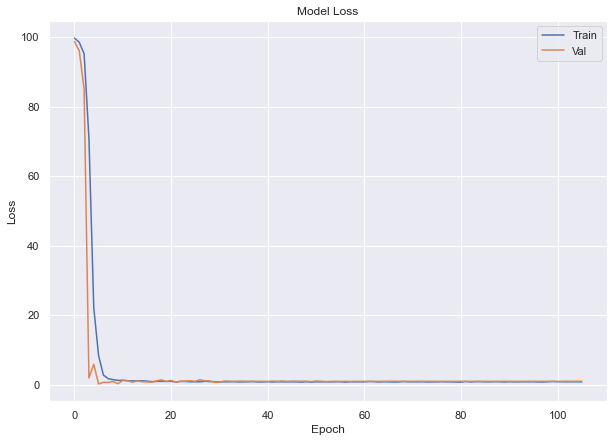

In [131]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [132]:
# remove
serie_multi1 = l_icms_ts[:-12]
print(l_icms_ts.shape)
print(serie_multi1.shape)

(216,)
(204,)


In [133]:
for i in range(12):
    # cria as séries
    X_multi1, Y_multi1 = cria_features_target(serie_multi1, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std1 = enc_x.transform(X_multi1)
    X_multi_std1 = X_multi_std1.reshape(X_multi_std1.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi1, y_multi1 = janelamento_1_mes(X_multi_std1, Y_multi1, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi1 = model.predict(x_multi1[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi1))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi1 = pd.Series(np.append(serie_multi1, y_pred_multi1))

0 [[1.1949015e+10]]
1 [[1.1979547e+10]]
2 [[1.2059903e+10]]
3 [[1.198812e+10]]
4 [[1.1939856e+10]]
5 [[1.1917627e+10]]
6 [[1.189991e+10]]
7 [[1.1898322e+10]]
8 [[1.1885642e+10]]
9 [[1.1879205e+10]]
10 [[1.1875558e+10]]
11 [[1.1871799e+10]]


In [134]:
Y_pred_multi1 = np.exp(pd.Series(serie_multi1[-12:]))
Y_pred_multi1.index = icms_ts.index[-12:]

In [135]:
RMSE_lstm_multi1 = mean_squared_error(np.exp(y_test1), Y_pred_multi1, squared=False)
RMSE_lstm_multi1

1801813531.4673357

In [136]:
MAPE_lstm_multi1 = mean_absolute_percentage_error(np.exp(y_test1), Y_pred_multi1)
MAPE_lstm_multi1

0.12274857365787058

In [137]:
previsoes['nome'].append('RNN-LSTM-1-mês')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(Y_pred_multi1)

previsoes['rmse'].append(RMSE_lstm_multi1)

previsoes['mape'].append(MAPE_lstm_multi1)

previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi1
                                                        , np.exp(y_test1))])

### Modelo 12 meses

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

##### Unindo novamente os dados.

In [138]:
def janelamento_12_meses(X, Y, verbose=0):
    X_exp = np.concatenate((np.roll(X, 12, axis=0),
                            np.roll(X, 11, axis=0),
                            np.roll(X, 10, axis=0),
                            np.roll(X, 9, axis=0),
                            np.roll(X, 8, axis=0),
                            np.roll(X, 7, axis=0),
                            np.roll(X, 6, axis=0),
                            np.roll(X, 5, axis=0),
                            np.roll(X, 4, axis=0),
                            np.roll(X, 3, axis=0),
                            np.roll(X, 2, axis=0),
                            np.roll(X, 1, axis=0),
                            ), axis=2)
    X_exp_cut = X_exp[12:,:,:].transpose(0,2,1)
    Y_cut = Y[12:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [139]:
X_data_exp_cut12, Y_data_cut12 = janelamento_12_meses(X_data_jn, Y_data, verbose=0)

In [140]:
#Y_data_cut[0]

In [141]:
#X_data_exp_cut[0]

In [142]:
#Y_data_cut[Y_data_cut.shape[0]-1]

In [143]:
#X_data_exp_cut[Y_data_cut.shape[0]-1]

#### Separando novamente em treino, validação e teste

In [144]:
x_train12 = X_data_exp_cut12[:-24]
x_val12 = X_data_exp_cut12[-24:-12]
x_test12 = X_data_exp_cut12[-12:]
print(x_train12.shape, x_val12.shape, x_test12.shape)
y_train12 = Y_data_cut12[:-24]
y_val12 = Y_data_cut12[-24:-12]
y_test12 = np.exp(Y_data_cut12[-12:]) # tirar o log para ficar o valor real
print(y_train12.shape, y_val12.shape, y_test12.shape)

(168, 12, 10) (12, 12, 10) (12, 12, 10)
(168,) (12,) (12,)


### Criando o modelo LSTM

In [145]:
rlrop2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop2 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [146]:
# Épocas e tamanho do lote
EPOCHS2 = 1000
BATCH2 = 8
NEURONIOS2 = 600
LR2 = 1e-5
DROPOUT2 = 0.25

# Imstanciação do modelo
model2 = Sequential()

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = True,
        units = NEURONIOS2))

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = True,
        units = NEURONIOS2))

## Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = False,
        units = NEURONIOS2))


# Adicionar a camada de saída com 1 neurônio linear
model2.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model2.compile(loss = 'mape', optimizer = Adam(learning_rate=LR2))

In [147]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 600)           1466400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 600)           2882400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 7,231,801
Trainable params: 7,231,801
Non-trainable params: 0
_________________________________________________________________


In [148]:
# History object for plotting our model loss by epoch
history2 = model2.fit(x_train12, y_train12, batch_size = BATCH2, 
                    epochs = EPOCHS2, validation_data = (x_val12, y_val12),
                    callbacks = [rlrop2, early_stop2])

Epoch 1/1000
21/21 [==============================] - 3s 150ms/step - loss: 99.2795 - val_loss: 97.7734
Epoch 2/1000
21/21 [==============================] - 2s 112ms/step - loss: 97.7533 - val_loss: 94.6065
Epoch 3/1000
21/21 [==============================] - 2s 113ms/step - loss: 94.7880 - val_loss: 87.6871
Epoch 4/1000
21/21 [==============================] - 2s 109ms/step - loss: 87.6359 - val_loss: 68.8233
Epoch 5/1000
21/21 [==============================] - 2s 111ms/step - loss: 68.7280 - val_loss: 32.5598
Epoch 6/1000
21/21 [==============================] - 2s 112ms/step - loss: 37.0768 - val_loss: 5.9567
Epoch 7/1000
21/21 [==============================] - 2s 110ms/step - loss: 14.0562 - val_loss: 4.0128
Epoch 8/1000
21/21 [==============================] - 2s 110ms/step - loss: 7.7537 - val_loss: 0.2440
Epoch 9/1000
21/21 [==============================] - 2s 110ms/step - loss: 5.0844 - val_loss: 0.5520
Epoch 10/1000
21/21 [==============================] - 2s 112ms/step -

21/21 [==============================] - 2s 109ms/step - loss: 0.3614 - val_loss: 0.1610
Epoch 81/1000
21/21 [==============================] - 2s 109ms/step - loss: 0.3595 - val_loss: 0.1540
Epoch 82/1000
21/21 [==============================] - 2s 109ms/step - loss: 0.3456 - val_loss: 0.2242
Epoch 83/1000
21/21 [==============================] - 2s 106ms/step - loss: 0.4162 - val_loss: 0.1545
Epoch 84/1000
21/21 [==============================] - 2s 110ms/step - loss: 0.4371 - val_loss: 0.1746
Epoch 85/1000
21/21 [==============================] - 2s 109ms/step - loss: 0.3403 - val_loss: 0.1941
Epoch 86/1000
21/21 [==============================] - 2s 109ms/step - loss: 0.3580 - val_loss: 0.1541
Epoch 87/1000
21/21 [==============================] - 2s 109ms/step - loss: 0.3971 - val_loss: 0.1612
Epoch 88/1000
21/21 [==============================] - 2s 111ms/step - loss: 0.3702 - val_loss: 0.2264
Epoch 89/1000
21/21 [==============================] - 2s 114ms/step - loss: 0.3814 - v

Epoch 155/1000
21/21 [==============================] - 2s 107ms/step - loss: 0.3686 - val_loss: 0.1542
Epoch 156/1000
21/21 [==============================] - 2s 110ms/step - loss: 0.3513 - val_loss: 0.1542
Epoch 157/1000
21/21 [==============================] - 2s 110ms/step - loss: 0.3329 - val_loss: 0.1542
Epoch 158/1000
21/21 [==============================] - 2s 107ms/step - loss: 0.3335 - val_loss: 0.1542
Epoch 159/1000
21/21 [==============================] - 2s 109ms/step - loss: 0.3312 - val_loss: 0.1542
Epoch 160/1000
21/21 [==============================] - 2s 109ms/step - loss: 0.3360 - val_loss: 0.1542
Epoch 161/1000
21/21 [==============================] - 2s 111ms/step - loss: 0.3623 - val_loss: 0.1542
Epoch 162/1000
21/21 [==============================] - 2s 107ms/step - loss: 0.3677 - val_loss: 0.1542
Epoch 163/1000
21/21 [==============================] - 2s 109ms/step - loss: 0.3258 - val_loss: 0.1542
Epoch 164/1000
21/21 [==============================] - 2s 108ms

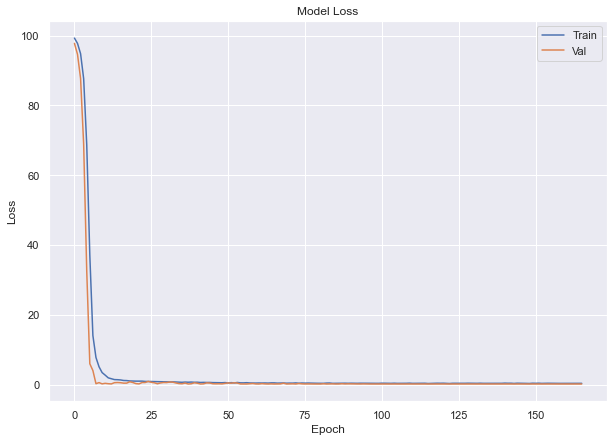

In [149]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [150]:
# remove
serie_multi12 = l_icms_ts[:-12]
print(l_icms_ts.shape)
print(serie_multi12.shape)
type(serie_multi12)

(216,)
(204,)


pandas.core.series.Series

In [151]:
for i in range(12):
    # cria as séries
    X_multi12, Y_multi12 = cria_features_target(serie_multi12, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std12 = enc_x.transform(X_multi12)
    X_multi_std12 = X_multi_std12.reshape(X_multi_std12.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi12, y_multi12 = janelamento_12_meses(X_multi_std12, Y_multi12, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi12 = model2.predict(x_multi12[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi12))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi12 = pd.Series(np.append(serie_multi12, y_pred_multi12))
    type(serie_multi12)

0 [[1.2029578e+10]]
1 [[1.2039884e+10]]
2 [[1.2040527e+10]]
3 [[1.2045878e+10]]
4 [[1.2060684e+10]]
5 [[1.2070788e+10]]
6 [[1.2084933e+10]]
7 [[1.2107241e+10]]
8 [[1.2126262e+10]]
9 [[1.2147884e+10]]
10 [[1.2169914e+10]]
11 [[1.2183315e+10]]


In [152]:
Y_pred_multi12 = np.exp(pd.Series(serie_multi12[-12:])) # tira o log das previsões
Y_pred_multi12.index = l_icms_ts.index[-12:]

In [153]:
Y_pred_multi12

date
2020-01-01    1.202958e+10
2020-02-01    1.203988e+10
2020-03-01    1.204053e+10
2020-04-01    1.204588e+10
2020-05-01    1.206068e+10
2020-06-01    1.207079e+10
2020-07-01    1.208493e+10
2020-08-01    1.210724e+10
2020-09-01    1.212626e+10
2020-10-01    1.214788e+10
2020-11-01    1.216992e+10
2020-12-01    1.218332e+10
dtype: float64

In [154]:
Y_pred_multi12

date
2020-01-01    1.202958e+10
2020-02-01    1.203988e+10
2020-03-01    1.204053e+10
2020-04-01    1.204588e+10
2020-05-01    1.206068e+10
2020-06-01    1.207079e+10
2020-07-01    1.208493e+10
2020-08-01    1.210724e+10
2020-09-01    1.212626e+10
2020-10-01    1.214788e+10
2020-11-01    1.216992e+10
2020-12-01    1.218332e+10
dtype: float64

In [155]:
RMSE_lstm_multi12 = mean_squared_error(y_test12, Y_pred_multi12, squared=False)
RMSE_lstm_multi12

1721219137.4874477

In [156]:
MAPE_lstm_multi12 = mean_absolute_percentage_error(y_test12, Y_pred_multi12)
MAPE_lstm_multi12

0.11903585125693304

In [157]:
previsoes['nome'].append('RNN-LSTM-12-meses')
previsoes['modelo'].append(model2)
previsoes['previsoes'].append(Y_pred_multi12)

previsoes['rmse'].append(RMSE_lstm_multi12)

previsoes['mape'].append(MAPE_lstm_multi12)

In [158]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi12
                                                        , y_test12)])

In [159]:
previsoes['nome']

['Mean',
 'SARIMA(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(2,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM-1-mês',
 'RNN-LSTM-12-meses']

## Resultados

In [160]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_test
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [161]:
df_prev

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(2,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses,real
2020-01-01,1.200177e+10,1.292716e+10,1.284862e+10,1.304511e+10,1.269711e+10,1.242665e+10,1.271702e+10,1.194901e+10,1.202958e+10,1.292981e+10
2020-02-01,1.200177e+10,1.213299e+10,1.206016e+10,1.215646e+10,1.197300e+10,1.169312e+10,1.199506e+10,1.197955e+10,1.203988e+10,1.177686e+10
2020-03-01,1.200177e+10,1.219420e+10,1.218289e+10,1.220650e+10,1.220293e+10,1.193485e+10,1.223033e+10,1.205990e+10,1.204053e+10,1.208593e+10
2020-04-01,1.200177e+10,1.278760e+10,1.276597e+10,1.284116e+10,1.268726e+10,1.243772e+10,1.271748e+10,1.198812e+10,1.204588e+10,1.045560e+10
2020-05-01,1.200177e+10,1.250958e+10,1.259812e+10,1.254769e+10,1.264958e+10,1.221894e+10,1.265548e+10,1.193986e+10,1.206068e+10,9.023529e+09
2020-06-01,1.200177e+10,1.240393e+10,1.251144e+10,1.238706e+10,1.273274e+10,1.234891e+10,1.273489e+10,1.191763e+10,1.207079e+10,9.983544e+09
2020-07-01,1.200177e+10,1.262892e+10,1.270431e+10,1.266966e+10,1.281468e+10,1.243601e+10,1.279110e+10,1.189991e+10,1.208493e+10,1.134873e+10
2020-08-01,1.200177e+10,1.273947e+10,1.280813e+10,1.276675e+10,1.297460e+10,1.278688e+10,1.296142e+10,1.189832e+10,1.210724e+10,1.227731e+10
2020-09-01,1.200177e+10,1.295523e+10,1.318015e+10,1.298013e+10,1.341316e+10,1.308183e+10,1.337608e+10,1.188564e+10,1.212626e+10,1.309835e+10
2020-10-01,1.200177e+10,1.322048e+10,1.349401e+10,1.324608e+10,1.367606e+10,1.335084e+10,1.364001e+10,1.187921e+10,1.214788e+10,1.387787e+10


In [162]:
df_erro

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(2,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses
0,7.177509,0.020456,0.627890,0.891781,1.799691,3.891483,1.645702,7.585511,6.962433
1,1.909787,3.023989,2.405618,3.223268,1.665500,0.711056,1.852838,1.721106,2.233435
2,0.696375,0.895828,0.802245,0.997628,0.968022,1.250067,1.194787,0.215370,0.375684
3,14.787999,22.303923,22.097063,22.816130,21.344235,18.957516,21.633288,14.657455,15.209885
4,33.005265,38.632955,39.614068,39.055292,40.184397,35.412045,40.249791,32.319144,33.658182
5,20.215514,24.243713,25.320628,24.074822,27.537232,23.692683,27.558768,19.372715,20.906843
6,5.754314,11.280522,11.944773,11.639453,12.917360,9.580618,12.709547,4.856784,6.487116
7,2.244299,3.764376,4.323640,3.986534,5.679481,4.150548,5.572174,3.086886,1.385204
8,8.371907,1.092635,0.624538,0.902527,2.403440,0.126093,2.120325,9.258479,7.421452
9,13.518631,4.736906,2.765930,4.552455,1.454148,3.797570,1.713922,14.401785,12.465763


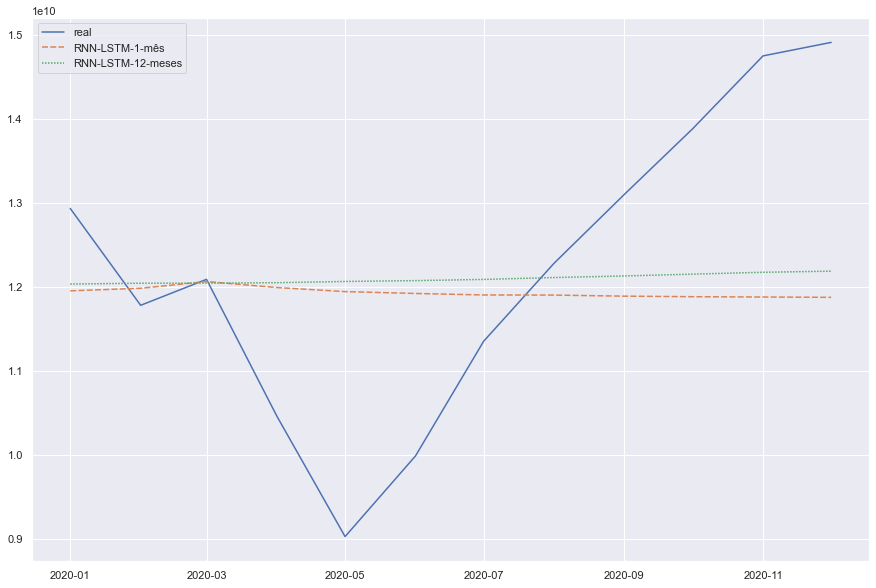

In [163]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev[['real', 'RNN-LSTM-1-mês', 'RNN-LSTM-12-meses']])

#### Previsões

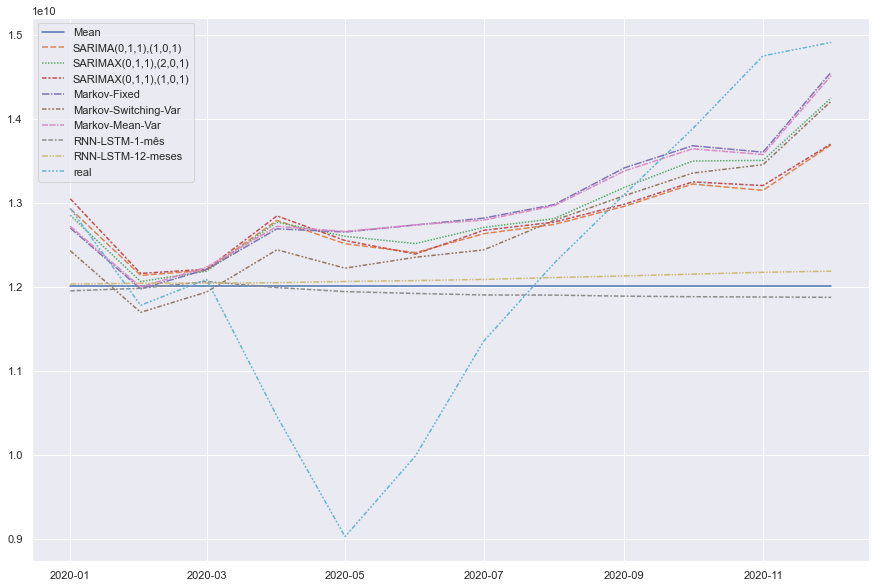

In [164]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev)

#### RMSE

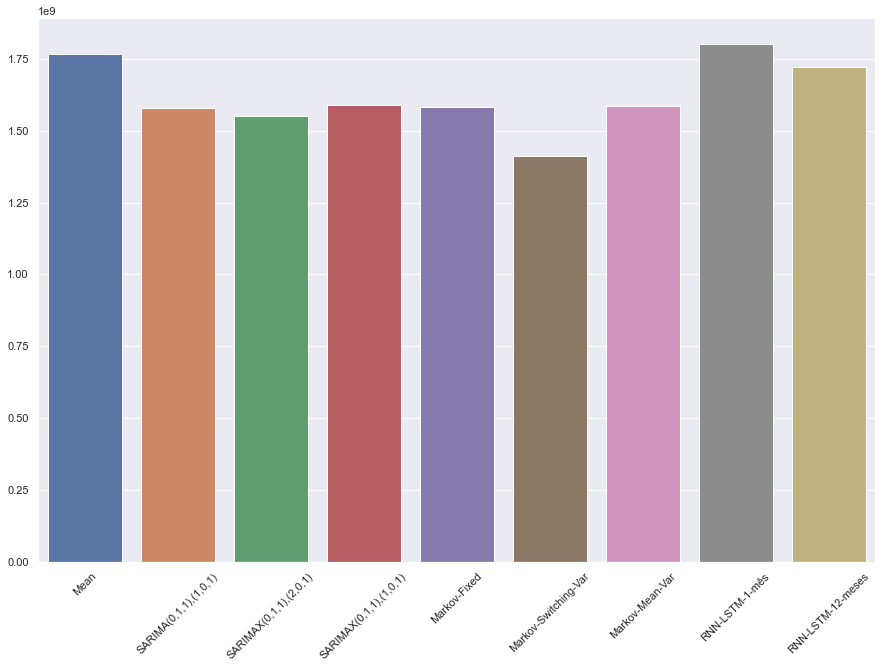

In [165]:
fig = plt.figure(figsize=(15, 10))
#df_rmse = df_rmse.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_rmse)
_ = plt.xticks(rotation=45)

#### MAPE

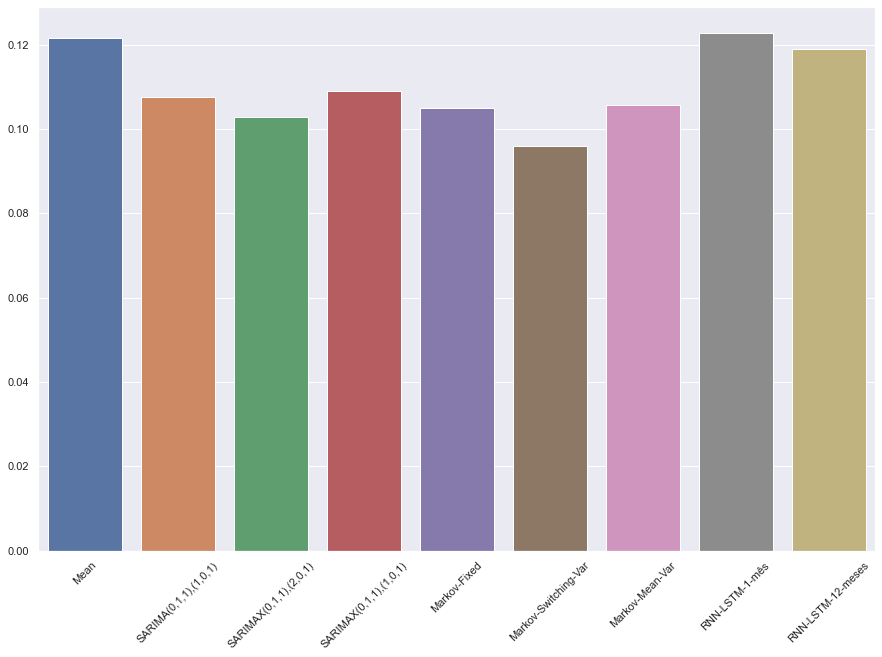

In [166]:
fig = plt.figure(figsize=(15, 10))
#df_mape = df_mape.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_mape)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [167]:
df_rmse.index = ['RMSE']
df_mape.index = ['MAPE']

In [168]:
df_metricas = df_rmse.copy()
df_metricas = df_metricas.append(df_mape.copy())
df_metricas

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(2,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses
RMSE,1.766458e+09,1.579591e+09,1.550802e+09,1.588928e+09,1.581326e+09,1.411437e+09,1.586597e+09,1.801814e+09,1.721219e+09
MAPE,1.214807e-01,1.075238e-01,1.028317e-01,1.089203e-01,1.050857e-01,9.587727e-02,1.057216e-01,1.227486e-01,1.190359e-01


In [169]:
print(df_metricas.transpose().to_latex())

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
Mean                   &  1.766458e+09 &  0.121481 \\
SARIMA(0,1,1),(1,0,1)  &  1.579591e+09 &  0.107524 \\
SARIMAX(0,1,1),(2,0,1) &  1.550802e+09 &  0.102832 \\
SARIMAX(0,1,1),(1,0,1) &  1.588928e+09 &  0.108920 \\
Markov-Fixed           &  1.581326e+09 &  0.105086 \\
Markov-Switching-Var   &  1.411437e+09 &  0.095877 \\
Markov-Mean-Var        &  1.586597e+09 &  0.105722 \\
RNN-LSTM-1-mês         &  1.801814e+09 &  0.122749 \\
RNN-LSTM-12-meses      &  1.721219e+09 &  0.119036 \\
\bottomrule
\end{tabular}



In [170]:
print(df_prev['2020-01-01':'2020-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2020-01-01 &    2020-02-01 &    2020-03-01 &    2020-04-01 \\
\midrule
Mean                   &  1.200177e+10 &  1.200177e+10 &  1.200177e+10 &  1.200177e+10 \\
SARIMA(0,1,1),(1,0,1)  &  1.292716e+10 &  1.213299e+10 &  1.219420e+10 &  1.278760e+10 \\
SARIMAX(0,1,1),(2,0,1) &  1.284862e+10 &  1.206016e+10 &  1.218289e+10 &  1.276597e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.304511e+10 &  1.215646e+10 &  1.220650e+10 &  1.284116e+10 \\
Markov-Fixed           &  1.269711e+10 &  1.197300e+10 &  1.220293e+10 &  1.268726e+10 \\
Markov-Switching-Var   &  1.242665e+10 &  1.169312e+10 &  1.193485e+10 &  1.243772e+10 \\
Markov-Mean-Var        &  1.271702e+10 &  1.199506e+10 &  1.223033e+10 &  1.271748e+10 \\
RNN-LSTM-1-mês         &  1.194901e+10 &  1.197955e+10 &  1.205990e+10 &  1.198812e+10 \\
RNN-LSTM-12-meses      &  1.202958e+10 &  1.203988e+10 &  1.204053e+10 &  1.204588e+10 \\
real                   &  1.292981e+10 &  1.177686e+10 &  1.208593e+10 &  1.045

In [171]:
print(df_prev['2020-05-01':'2020-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2020-05-01 &    2020-06-01 &    2020-07-01 &    2020-08-01 \\
\midrule
Mean                   &  1.200177e+10 &  1.200177e+10 &  1.200177e+10 &  1.200177e+10 \\
SARIMA(0,1,1),(1,0,1)  &  1.250958e+10 &  1.240393e+10 &  1.262892e+10 &  1.273947e+10 \\
SARIMAX(0,1,1),(2,0,1) &  1.259812e+10 &  1.251144e+10 &  1.270431e+10 &  1.280813e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.254769e+10 &  1.238706e+10 &  1.266966e+10 &  1.276675e+10 \\
Markov-Fixed           &  1.264958e+10 &  1.273274e+10 &  1.281468e+10 &  1.297460e+10 \\
Markov-Switching-Var   &  1.221894e+10 &  1.234891e+10 &  1.243601e+10 &  1.278688e+10 \\
Markov-Mean-Var        &  1.265548e+10 &  1.273489e+10 &  1.279110e+10 &  1.296142e+10 \\
RNN-LSTM-1-mês         &  1.193986e+10 &  1.191763e+10 &  1.189991e+10 &  1.189832e+10 \\
RNN-LSTM-12-meses      &  1.206068e+10 &  1.207079e+10 &  1.208493e+10 &  1.210724e+10 \\
real                   &  9.023529e+09 &  9.983544e+09 &  1.134873e+10 &  1.227

In [172]:
print(df_prev['2020-09-01':'2020-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2020-09-01 &    2020-10-01 &    2020-11-01 &    2020-12-01 \\
\midrule
Mean                   &  1.200177e+10 &  1.200177e+10 &  1.200177e+10 &  1.200177e+10 \\
SARIMA(0,1,1),(1,0,1)  &  1.295523e+10 &  1.322048e+10 &  1.314498e+10 &  1.368757e+10 \\
SARIMAX(0,1,1),(2,0,1) &  1.318015e+10 &  1.349401e+10 &  1.350213e+10 &  1.424500e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.298013e+10 &  1.324608e+10 &  1.320231e+10 &  1.369949e+10 \\
Markov-Fixed           &  1.341316e+10 &  1.367606e+10 &  1.359979e+10 &  1.455208e+10 \\
Markov-Switching-Var   &  1.308183e+10 &  1.335084e+10 &  1.345052e+10 &  1.420604e+10 \\
Markov-Mean-Var        &  1.337608e+10 &  1.364001e+10 &  1.357202e+10 &  1.451076e+10 \\
RNN-LSTM-1-mês         &  1.188564e+10 &  1.187921e+10 &  1.187556e+10 &  1.187180e+10 \\
RNN-LSTM-12-meses      &  1.212626e+10 &  1.214788e+10 &  1.216992e+10 &  1.218332e+10 \\
real                   &  1.309835e+10 &  1.387787e+10 &  1.474590e+10 &  1.490

In [173]:
df_metricas.transpose().to_excel('./metricas_uni_2020.xlsx', index_label='modelo')

In [174]:
df_prev.to_excel('./previsoes_uni_2020.xlsx', index_label='mes_ano')